In [103]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [104]:
data_dir = '../data/'
price_history_dir = data_dir + f'{data_dir}price_history/'
sentiment_dir = data_dir + f'{data_dir}sentiments/'
ti_dir = data_dir + f'{data_dir}technical_indicators/'

### Load Ticker Pair list

In [105]:
import glob

tickers_list = [file.split('/')[-1].strip('.csv') for file in glob.glob(price_history_dir + '*.csv')]
tickers_list
pairs_df = pd.read_csv(data_dir + 'ranked_pairs_snp.csv')
pairs = pairs_df[['ticker_0', 'ticker_1']].values

unique_pairs= pairs_df[['ticker_0', 'ticker_1']].drop_duplicates('ticker_0', keep='first').drop_duplicates('ticker_1', keep='first')

### Config Data From Files

In [128]:
ticker = 'AAPL'

price_history = pd.read_csv(price_history_dir + f'{ticker}.csv')
sentiment = pd.read_csv(sentiment_dir + f'{ticker}.csv')
ti = pd.read_csv(ti_dir + f'{ticker}.csv')

data = {}


class TickerData:
    def __init__(self, ticker):
        self.ticker = ticker
        self.history = pd.read_csv(price_history_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
        self.sentiment = pd.read_csv(sentiment_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
        self.ti = pd.read_csv(ti_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
    def __repr__(self):
        return repr(self.history['Adj Close'])

class DATA:
    pass

for ticker in tickers_list:
    setattr(DATA, ticker, TickerData(ticker))

    data[ticker] = TickerData(ticker)
    

In [129]:
display(DATA.AAPL.history.head(2))
display(DATA.AAPL.sentiment.head(2))
display(DATA.AAPL.ti.head(2))


High     Low    Open       Volume  Adj Close
Date                                                        
2021-01-04  133.6116  126.76  133.52  143301887.0     129.41
2021-01-05  131.7400  128.43  128.89   97664898.0     131.01

news_pos_sentiment_count  news_sentiment_daily_avg  \
Date                                                             
2021-01-01                      11.0                    0.0109   
2021-01-04                       3.0                   -0.0008   

            twitter_pos_sentiment_count  
Date                                     
2021-01-01                           15  
2021-01-04                            6

High     Low    Open       Volume  Adj Close           P  \
Date                                                                       
2021-01-04  133.6116  126.76  133.52  143301887.0     129.41  129.927200   
2021-01-05  131.7400  128.43  128.89   97664898.0     131.01  130.393333   

                    R1          R2          R3          S1  ...  momentum_ppo  \
Date                                                        ...                 
2021-01-04  132.544511  134.161489  136.778800  127.309889  ...      0.000000   
2021-01-05  131.657753  132.438913  133.703333  129.128913  ...      0.098538   

            momentum_ppo_signal  momentum_ppo_hist  momentum_pvo  \
Date                                                               
2021-01-04             0.000000           0.000000       0.00000   
2021-01-05             0.019708           0.078831      -2.60186   

            momentum_pvo_signal  momentum_pvo_hist  momentum_kama  others_dr  \
Date                                                                           
2021-01-04             0.000000           0.000000     129.410000    0.00000   
2021-01-05            -0.520372          -2.081488     130.210469    1.23638   

            others_dlr  others_cr  
Date                               
2021-01-04      0.0000    0.00000  
2021-01-05      1.2288    1.23638  

[2 rows x 122 columns]

In [130]:
def add_moving_averages(df, moving_averages, columns):
    df = df.copy()
    for ma in moving_averages:
        for col in columns:
            new_col = f'{col}_ma{ma}'
            df[new_col] = df[col].rolling(window=ma).mean()
    # ffill na
    df.fillna(method='ffill', inplace=True)
    return df


### Load and Merge Data for Pair
change PAIR_IDX to the pair you want to analyze

In [131]:
PAIR_IDX = 0

pair = pairs[PAIR_IDX]

print(pair)

ADD_SENTIMENT_MA = True

# Join Sentiment and add Sentiment Moving Averages if ADD_SENTIMENT_MA is True
pair_sentiment_df = pd.merge(
    data[pair[0]].sentiment,
    data[pair[1]].sentiment,
    left_index=True,
    right_index=True,
    suffixes=("_S1", "_S2"),
)
if ADD_SENTIMENT_MA:
    pair_sentiment_df = add_moving_averages(
        pair_sentiment_df, [5, 10, 20, 40, 80], columns=pair_sentiment_df.columns
    )

# Join Technical Indicators
pair_ti_df = pd.merge(
    data[pair[0]].ti,
    data[pair[1]].ti,
    left_index=True,
    right_index=True,
    suffixes=("_S1", "_S2"),
)

pair_df = pd.merge(
    pair_ti_df, pair_sentiment_df, left_index=True, right_index=True, how="left"
)

print(pair_df.shape, pair_df.shape[0] * pair_df.shape[1])
pair_df

['GS' 'BLK']
(815, 280) 228200


High_S1  Low_S1  Open_S1  Volume_S1  Adj Close_S1        P_S1  \
Date                                                                         
2021-01-04  267.5800  260.16   267.00  3572043.0        265.00  264.246667   
2021-01-05  273.5000  262.57   263.88  4207081.0        270.93  269.000000   
2021-01-06  288.3800  273.10   276.29  6383530.0        285.55  282.343333   
2021-01-07  295.8894  286.68   287.77  4009730.0        291.65  291.406467   
2021-01-08  292.2800  285.06   292.00  2800784.0        290.08  289.140000   
...              ...     ...      ...        ...           ...         ...   
2024-03-25  410.4600  403.86   406.87  1683977.0        404.94  406.420000   
2024-03-26  409.3300  404.52   406.09  1406974.0        406.18  406.676667   
2024-03-27  415.4900  408.37   409.62  2353629.0        415.25  413.036667   
2024-03-28  419.2000  414.98   416.21  2409718.0        417.69  417.290000   
2024-04-01  417.9500  412.00   416.68  1863918.0        413.51  414.486667   

                 R1_S1       R2_S1       R3_S1       S1_S1  ...  \
Date                                                        ...   
2021-01-04  267.081107  268.832227  271.666667  261.412227  ...   
2021-01-05  273.175260  275.754740  279.930000  264.824740  ...   
2021-01-06  288.180293  291.786373  297.623333  276.506373  ...   
2021-01-07  294.924457  297.097876  300.615867  287.888476  ...   
2021-01-08  291.898040  293.601960  296.360000  286.381960  ...   
...                ...         ...         ...         ...  ...   
2024-03-25  408.941200  410.498800  413.020000  403.898800  ...   
2024-03-26  408.514087  409.649247  411.486667  404.839247  ...   
2024-03-27  415.756507  417.436827  420.156667  410.316827  ...   
2024-03-28  418.902040  419.897960  421.510000  415.677960  ...   
2024-04-01  416.759567  418.163767  420.436667  412.213767  ...   

            twitter_pos_sentiment_count_S1_ma40  \
Date                                              
2021-01-04                                  NaN   
2021-01-05                                  NaN   
2021-01-06                                  NaN   
2021-01-07                                  NaN   
2021-01-08                                  NaN   
...                                         ...   
2024-03-25                               13.775   
2024-03-26                               13.850   
2024-03-27                               14.050   
2024-03-28                               13.500   
2024-04-01                                  NaN   

            news_sentiment_daily_avg_S2_ma40  \
Date                                           
2021-01-04                               NaN   
2021-01-05                               NaN   
2021-01-06                               NaN   
2021-01-07                               NaN   
2021-01-08                               NaN   
...                                      ...   
2024-03-25                         -0.000575   
2024-03-26                         -0.000875   
2024-03-27                         -0.000768   
2024-03-28                         -0.001663   
2024-04-01                               NaN   

            twitter_pos_sentiment_count_S2_ma40  \
Date                                              
2021-01-04                                  NaN   
2021-01-05                                  NaN   
2021-01-06                                  NaN   
2021-01-07                                  NaN   
2021-01-08                                  NaN   
...                                         ...   
2024-03-25                               36.000   
2024-03-26                               35.100   
2024-03-27                               35.025   
2024-03-28                               36.800   
2024-04-01                                  NaN   

            news_pos_sentiment_count_S2_ma40  \
Date                                           
2021-01-04                               NaN   
2021-01-05                   


### calculate spread


<Axes: title={'center': 'Spread'}, xlabel='Date'>

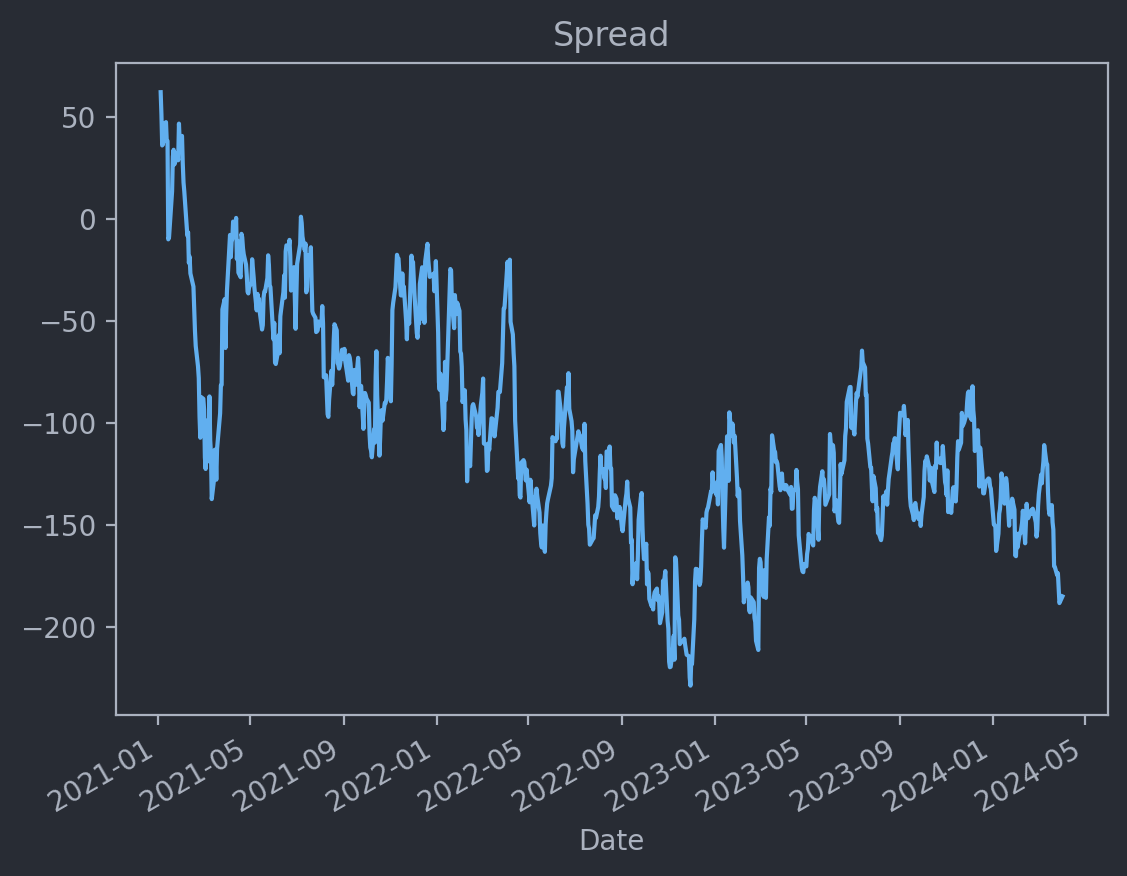

In [132]:
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

# If window param is set, then spread is calculated on a rolling basis
def get_spread(S1, S2, window=None):
    s1_ols = sm.add_constant(S1)
    if window:
        spread_model = sm.regression.rolling.RollingOLS(S2, s1_ols, window=window).fit()
    else:
        spread_model = sm.OLS(S2, s1_ols).fit()
    beta = spread_model.params[S1.name]
    spread = S2 - beta * S1
    return spread


def norm_plot(df):
    df=df.copy()
    df = (df - df.mean()) / df.std()
    return df



SPREAD_WINDOW = None
spread = get_spread(pair_df['Adj Close_S1'], pair_df['Adj Close_S2'], window=SPREAD_WINDOW)
pair_df['spread'] = spread

pair_df['spread'].plot(title='Spread')


### Create Target 

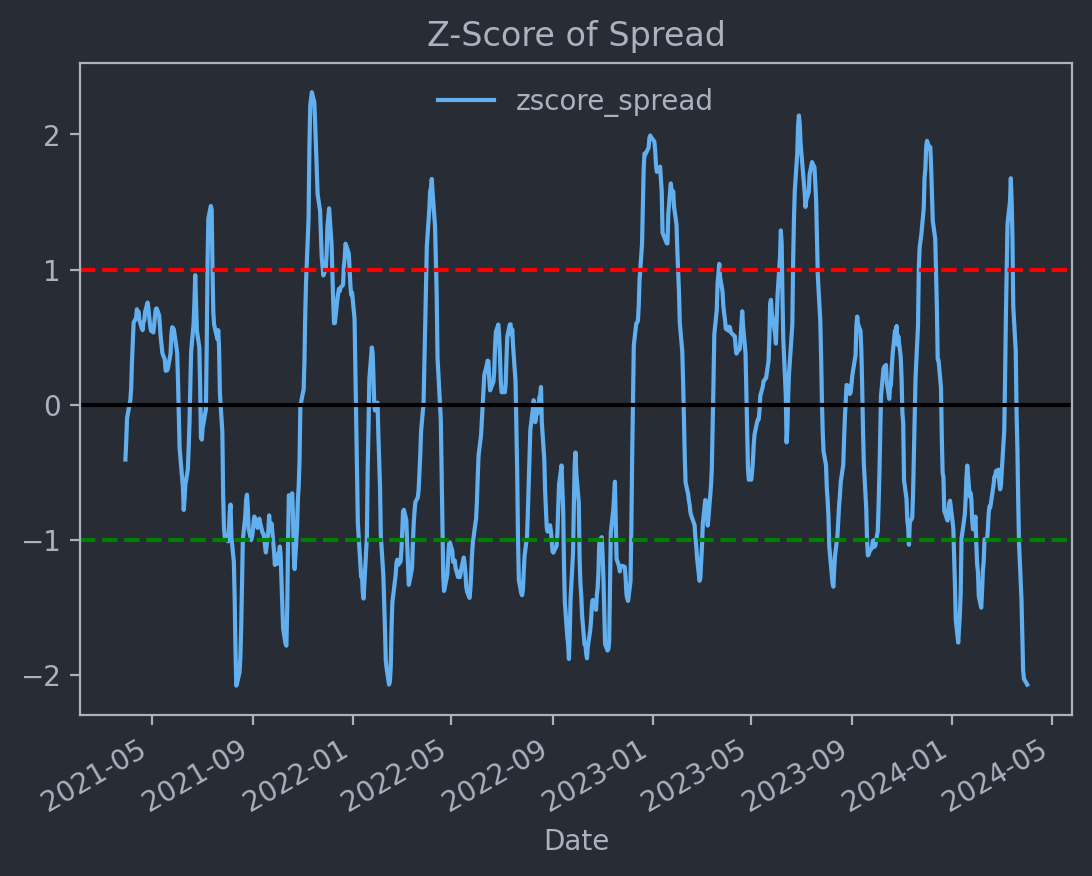

High_S1  Low_S1  Open_S1  Volume_S1  Adj Close_S1        P_S1  \
Date                                                                         
2021-01-04  267.5800  260.16   267.00  3572043.0        265.00  264.246667   
2021-01-05  273.5000  262.57   263.88  4207081.0        270.93  269.000000   
2021-01-06  288.3800  273.10   276.29  6383530.0        285.55  282.343333   
2021-01-07  295.8894  286.68   287.77  4009730.0        291.65  291.406467   
2021-01-08  292.2800  285.06   292.00  2800784.0        290.08  289.140000   
...              ...     ...      ...        ...           ...         ...   
2024-03-25  410.4600  403.86   406.87  1683977.0        404.94  406.420000   
2024-03-26  409.3300  404.52   406.09  1406974.0        406.18  406.676667   
2024-03-27  415.4900  408.37   409.62  2353629.0        415.25  413.036667   
2024-03-28  419.2000  414.98   416.21  2409718.0        417.69  417.290000   
2024-04-01  417.9500  412.00   416.68  1863918.0        413.51  414.486667   

                 R1_S1       R2_S1       R3_S1       S1_S1  ...  \
Date                                                        ...   
2021-01-04  267.081107  268.832227  271.666667  261.412227  ...   
2021-01-05  273.175260  275.754740  279.930000  264.824740  ...   
2021-01-06  288.180293  291.786373  297.623333  276.506373  ...   
2021-01-07  294.924457  297.097876  300.615867  287.888476  ...   
2021-01-08  291.898040  293.601960  296.360000  286.381960  ...   
...                ...         ...         ...         ...  ...   
2024-03-25  408.941200  410.498800  413.020000  403.898800  ...   
2024-03-26  408.514087  409.649247  411.486667  404.839247  ...   
2024-03-27  415.756507  417.436827  420.156667  410.316827  ...   
2024-03-28  418.902040  419.897960  421.510000  415.677960  ...   
2024-04-01  416.759567  418.163767  420.436667  412.213767  ...   

            twitter_pos_sentiment_count_S2_ma40  \
Date                                              
2021-01-04                                  NaN   
2021-01-05                                  NaN   
2021-01-06                                  NaN   
2021-01-07                                  NaN   
2021-01-08                                  NaN   
...                                         ...   
2024-03-25                               36.000   
2024-03-26                               35.100   
2024-03-27                               35.025   
2024-03-28                               36.800   
2024-04-01                                  NaN   

            news_pos_sentiment_count_S2_ma40  \
Date                                           
2021-01-04                               NaN   
2021-01-05                               NaN   
2021-01-06                               NaN   
2021-01-07                               NaN   
2021-01-08                               NaN   
...                                      ...   
2024-03-25                             0.900   
2024-03-26                             0.850   
2024-03-27                             0.900   
2024-03-28                             0.925   
2024-04-01                               NaN   

            news_pos_sentiment_count_S1_ma80  \
Date                                           
2021-01-04                               NaN   
2021-01-05                               NaN   
2021-01-06                               NaN   
2021-01-07                               NaN   
2021-01-08                               NaN   
...                                      ...   
2024-03-25                            2.4125   
2024-03-26                            2.4000   
2024-03-27                            2.3875   
2024-03-28                            2.4000   
2024-04-01                               NaN   

            news_sentiment_daily_avg_S1_ma80  \
Date                                           
2021-01-04                               NaN   
2021-01-05                               NaN   
2021-01-06          

In [133]:

# We want to predict the z-score of spread, to forecast deviations from the mean

# The Z-score of the spread will be used to determine when to buy and sell
# We use a low/high moving average to calculate the z-score. 
# This is so that the z-score is not affected by the spread increasing over time
# Can play around with the window sizes to see what works best

# Moving Z score Calculation (Trading Signal)
ma_high = pair_df.spread.rolling(window=60).mean()
ma_low = pair_df.spread.rolling(window=5).mean()
std_high = pair_df.spread.rolling(window=60).std()

moving_zscore = (ma_low - ma_high) / std_high
pair_df['zscore_spread'] = moving_zscore


pair_df['zscore_spread'].plot(title='Z-Score of Spread')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend()
plt.show()
pair_df

In [134]:
plt.style.use('custom_onedark')



In [144]:
from tabulate import tabulate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split


SPLIT_SIZES = [0.4, 0.1, 0.5]

def create_dataset(data, look_back, target_col="spread_close", split_sizes=SPLIT_SIZES, drop_cols: list = []):
    data = data.copy().dropna()
    y = data[target_col]
    y_shifted = y.shift(-look_back)

    data["target"] = y_shifted
    data = data.dropna().drop(drop_cols, axis=1)
    train_size = int(len(data) * split_sizes[0])
    val_size = int(len(data) * split_sizes[1])
    test_size = len(data) - train_size - val_size


    train_data = data.iloc[:train_size]
    val_data = data.iloc[train_size : train_size + val_size]
    test_data = data.iloc[train_size + val_size:]
 
    print("------Dataset Information------")
    print(tabulate([
            ["Train", train_size, data.index[0].date(), data.index[train_size-1].date()], 
            ["Val", val_size, data.index[train_size].date(), data.index[train_size + val_size - 1].date()],
            ["Test", test_size, data.index[train_size + val_size].date(), data.index[-1].date()]],
        ["Set", "Size", "Min Date", "Max Date"]))
    
    return train_data, val_data, test_data

def prepare_dataset(train_data, val_data, test_data):
    X_train, y_train = train_data.drop(columns=["target"]), train_data["target"]
    X_val, y_val = val_data.drop(columns=["target"]), val_data["target"]
    X_test, y_test = test_data.drop(columns=["target"]), test_data["target"]

    return X_train, y_train, X_val, y_val, X_test, y_test



## Dataset Setup

In [145]:
# Parameters
LOOK_BACK = 2
DROP_COLS = [
   'zscore_spread',
    'spread',
]

train_data, val_data, test_data = create_dataset(
    pair_df, 
    look_back=LOOK_BACK, 
    target_col="zscore_spread", 
    drop_cols=DROP_COLS
)

X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)

# Combine val and test data since were not using Deep learning or hyper-param tuning 
X_test = pd.concat([X_val, X_test])
y_test = pd.concat([y_val, y_test])

------Dataset Information------
Set      Size  Min Date    Max Date
-----  ------  ----------  ----------
Train     294  2021-04-22  2022-06-21
Val        73  2022-06-22  2022-10-04
Test      370  2022-10-05  2024-03-26


In [146]:
print(
     (X_train.index.min(), X_train.index.max(),),
    ( X_test.index.min(), X_test.index.max()),
    (X_val.index.min(), X_val.index.max())
)


(Timestamp('2021-04-22 00:00:00'), Timestamp('2022-06-21 00:00:00')) (Timestamp('2022-06-22 00:00:00'), Timestamp('2024-03-26 00:00:00')) (Timestamp('2022-06-22 00:00:00'), Timestamp('2022-10-04 00:00:00'))


In [154]:
from tabulate import tabulate

print(tabulate([
    ["Train", X_train.index.min().date(), X_train.index.max().date()], 
    ["Validation", X_val.index.min().date(), X_val.index.max().date()],
    ["Test", X_test.index.min().date(), X_test.index.max().date()]],
    headers=["Set", "Min Date", "Max Date"], tablefmt='pretty'))

+------------+------------+------------+
|    Set     |  Min Date  |  Max Date  |
+------------+------------+------------+
|   Train    | 2021-04-22 | 2022-06-21 |
| Validation | 2022-06-22 | 2022-10-04 |
|    Test    | 2022-06-22 | 2024-03-26 |
+------------+------------+------------+


In [155]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

def calculate_metrics(y_true, y_pred):
    metric_frame = {
        "mape": mean_absolute_percentage_error(y_true, y_pred),
        "mse": mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred)
    }
    print(f"\nR2: {metric_frame['r2']:.2f}, MAE: {metric_frame['mae']:.2f}, MAPE: {metric_frame['mape']*100:.2f}%")
    return metric_frame

In [157]:
feature_importance_df

feature  importance
274  news_pos_sentiment_count_S1_ma80    0.213837
218                trend_aroon_ind_S2    0.095650
36                      volume_adi_S1    0.068223
212                  trend_adx_neg_S2    0.066333
34                           EMA_7_S1    0.044216
..                                ...         ...
150           Engulfing_Indication_S2    0.000000
139                           SEMA_S2    0.000000
138                            SMA_S2    0.000000
135                           MACD_S2    0.000000
140                            LMA_S2    0.000000

[280 rows x 2 columns]


R2: 0.32, MAE: 0.71, MAPE: 125.75%


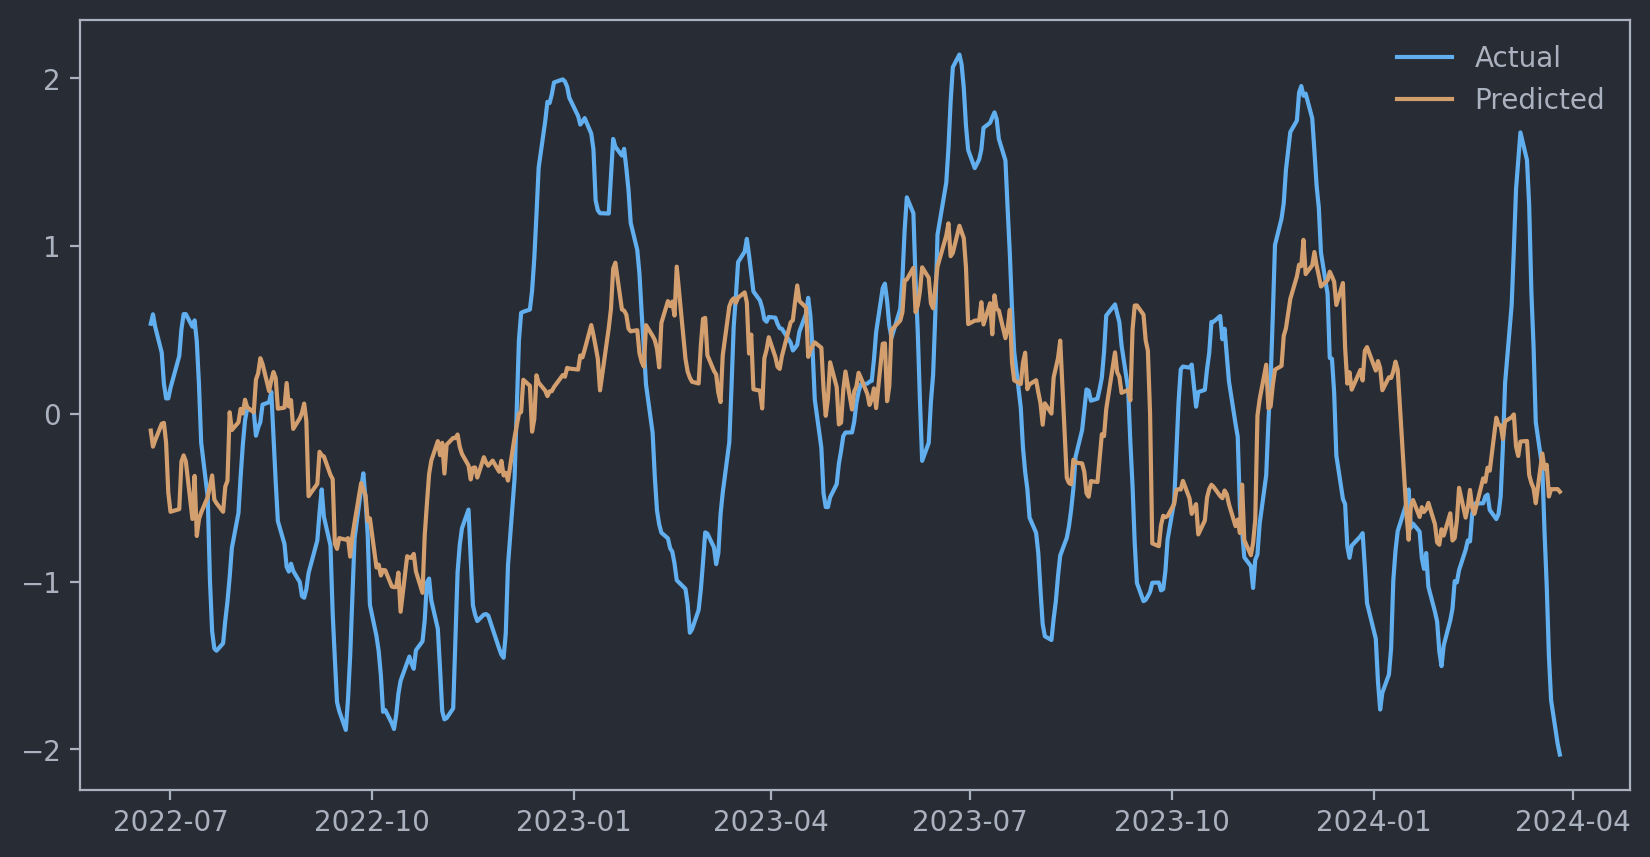

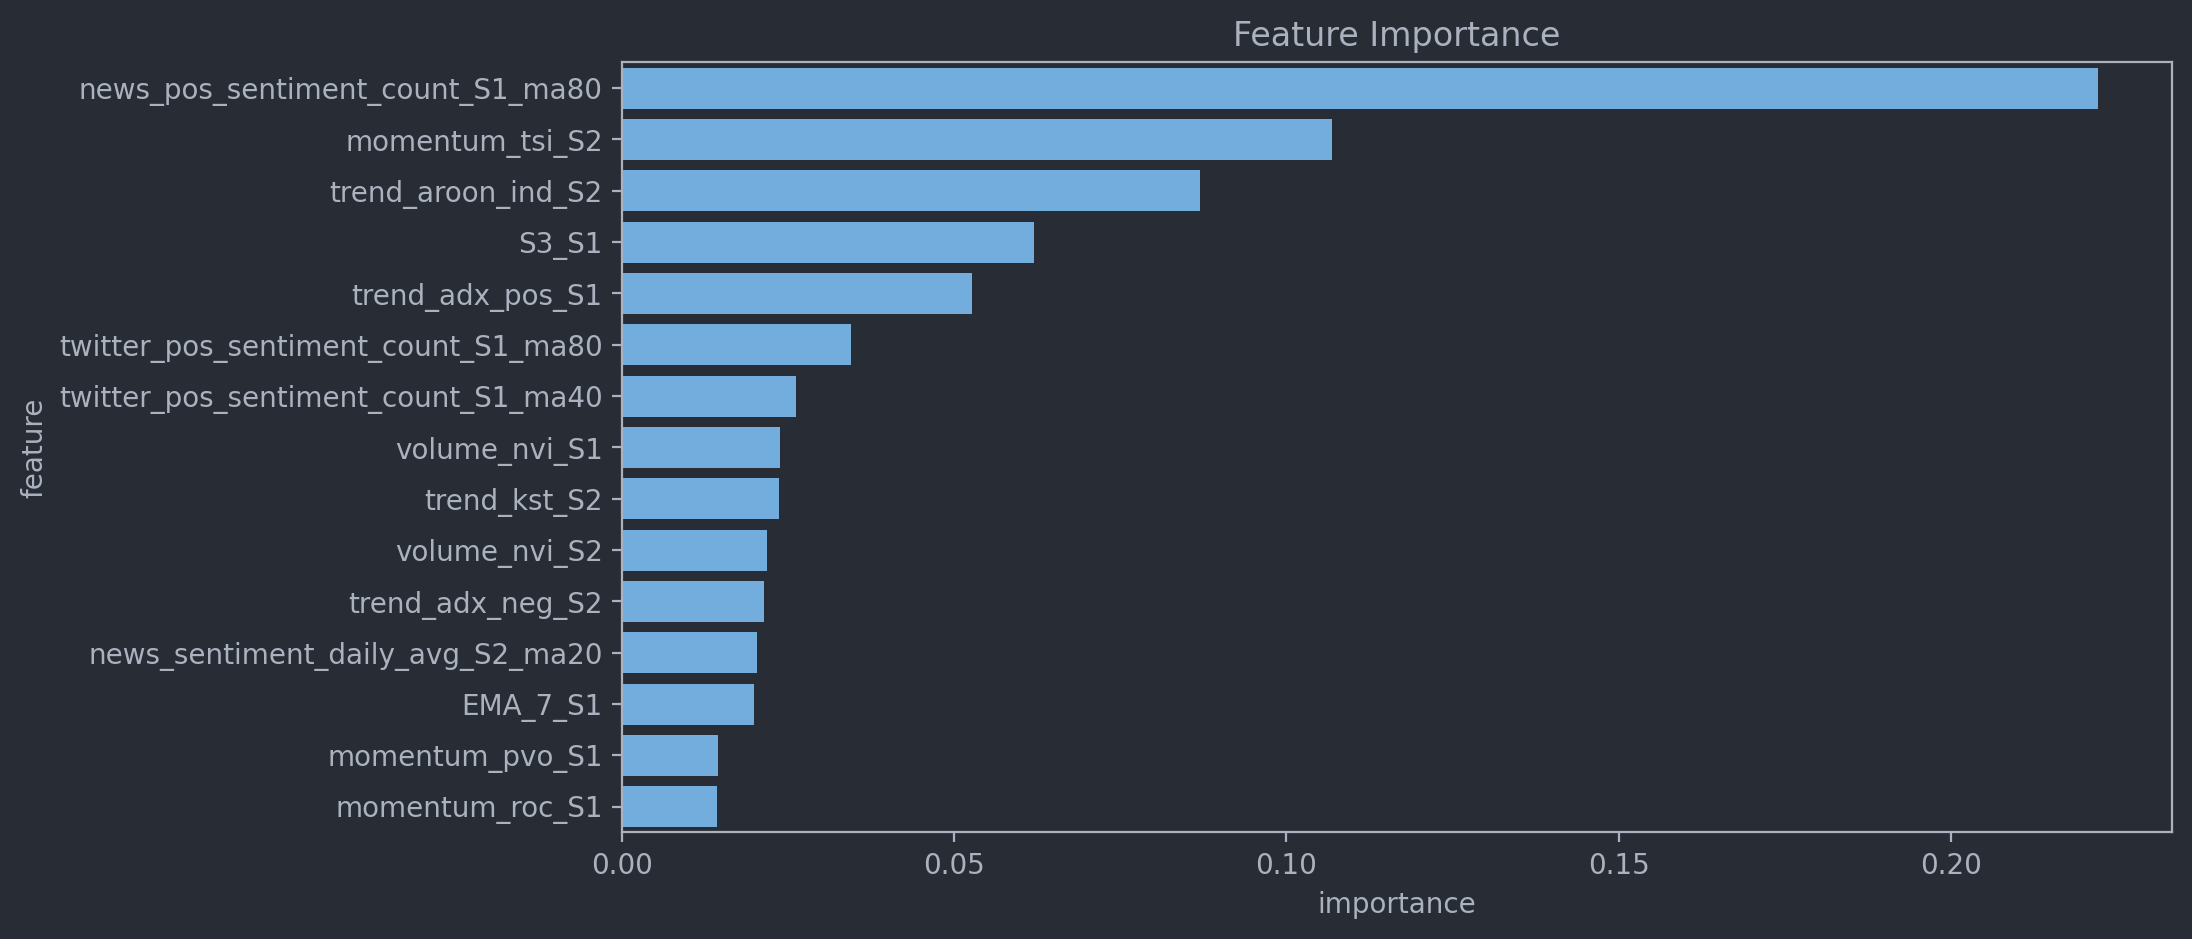

In [179]:
from sklearn.ensemble import GradientBoostingRegressor

errors = ['squared_error', 'absolute_error', 'huber', 'quantile']
# ---- Model Training ----
model_reg = GradientBoostingRegressor(n_estimators=100, loss=errors[0], random_state=42
                                      )
model_reg.fit(X_train, y_train)

y_pred = model_reg.predict(X_test)

model_results = {}

fig = plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.legend()

# get feature importance
feature_importance = model_reg.feature_importances_
features = X_train.columns
feature_importance_df = pd.DataFrame({"feature": features, "importance": feature_importance})
feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)

# plot feature importance
fig = plt.figure(figsize=(10, 5))
sns.barplot(x="importance", y="feature", data=feature_importance_df.iloc[:15,:])
plt.title("Feature Importance")
plt.show()


------Dataset Information------
Set      Size  Min Date    Max Date
-----  ------  ----------  ----------
Train     294  2021-04-22  2022-06-21
Val        73  2022-06-22  2022-10-04
Test      370  2022-10-05  2024-03-26

R2: 0.77, MAE: 0.39, MAPE: 79.85%

R2: 0.77, MAE: 0.39


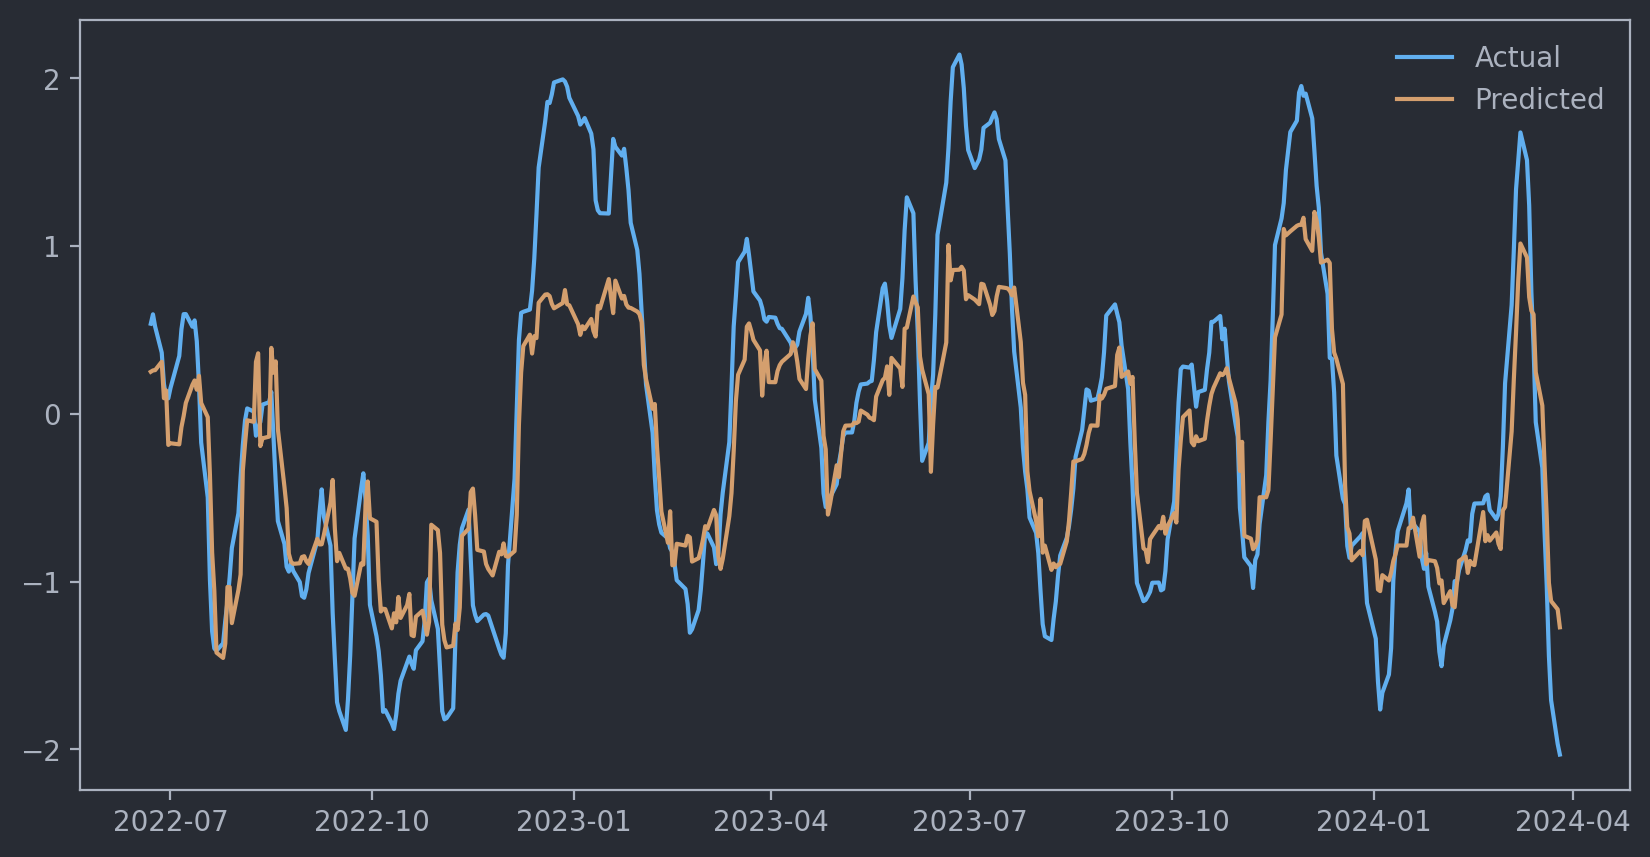

In [180]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# Parameters
LOOK_BACK = 2
DROP_COLS = [
#    'zscore_spread',
#     'spread',
]

train_data, val_data, test_data = create_dataset(
    pair_df, 
    look_back=LOOK_BACK, 
    target_col="zscore_spread", 
    drop_cols=DROP_COLS
)

X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)

# Combine val and test data since were not using Deep learning or hyper-param tuning 
X_test = pd.concat([X_val, X_test])
y_test = pd.concat([y_val, y_test])

model_gbr = GradientBoostingRegressor()
model_gbr.fit(X_train, y_train)
y_pred = model_gbr.predict(X_test)
model_results['Gradient Boosting Regressor'] = calculate_metrics(
    y_test, y_pred)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"\nR2: {r2:.2f}, MAE: {mae:.2f}")

fig = plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.legend()


In [ ]:
print('Original Feature Dim:', feature_importance_df.shape[0])

# Can Change Thresholds, By no means are these the best thresholds
# Should use another method for feature selection, this was just for demonstration
low_importance_df = feature_importance_df[(feature_importance_df['importance'] < 1) & (feature_importance_df['importance'] > -1)]
print('Low Importance Feature Dim:', low_importance_df.shape[0])

low_importance_cols = low_importance_df.feature.to_list()
high_importance_df = feature_importance_df[(feature_importance_df['importance'] >= 1) | (feature_importance_df['importance'] <= -1)]

Original Feature Dim: 280
Low Importance Feature Dim: 280


### Train regression again with low importance columns removed

------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     361  2022-10-14
Val       144  2023-08-29
Test      218  2023-05-12

R2: -2.03, MAE: 1.68, MAPE: 426.87%


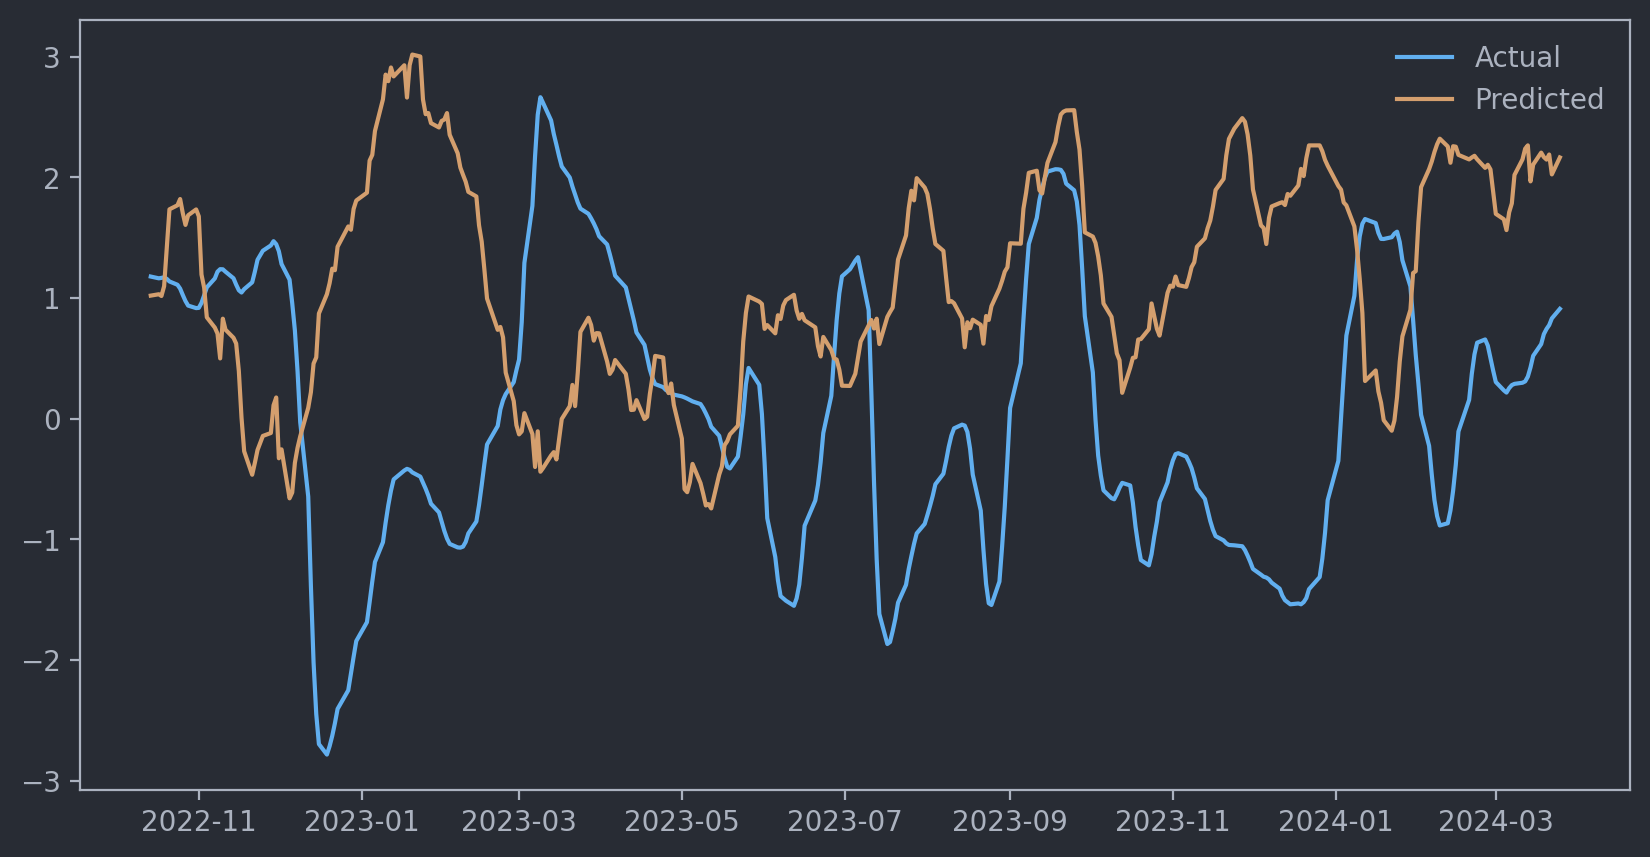

In [ ]:

train_data, val_data, test_data = create_dataset(
    pair_df, 
    look_back=LOOK_BACK, 
    target_col="zscore_spread", 
    drop_cols=low_importance_cols
)

X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)

# Combine val and test data since were not using Deep learning or hyper-param tuning 
X_test = pd.concat([X_val, X_test])
y_test = pd.concat([y_val, y_test])



model_reg = LinearRegression()
model_reg.fit(X_train, y_train)

y_pred = model_reg.predict(X_test)


model_results['Regression with Feature Selection'] = calculate_metrics(y_test, y_pred)

fig = plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.legend()

plt.show()

# General Setup

In [184]:
def add_moving_averages(df, moving_averages, columns):
    df = df.copy()
    for ma in moving_averages:
        for col in columns:
            new_col = f'{col}_ma{ma}'
            df[new_col] = df[col].rolling(window=ma).mean()
    # ffill na
    df.fillna(method='ffill', inplace=True)
    return df

# If window param is set, then spread is calculated on a rolling basis
def get_spread(S1, S2, window=None):
    s1_ols = sm.add_constant(S1)
    if window:
        spread_model = sm.regression.rolling.RollingOLS(S2, s1_ols, window=window).fit()
    else:
        spread_model = sm.OLS(S2, s1_ols).fit()
    beta = spread_model.params[S1.name]
    spread = S2 - beta * S1
    return spread


def norm_plot(df):
    df=df.copy()
    df = (df - df.mean()) / df.std()
    return df

from tabulate import tabulate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error


def create_dataset(data, look_back, target_col="spread_close", split_sizes=SPLIT_SIZES, drop_cols: list = []):
    data = data.copy().dropna()
    y = data[target_col]
    y_shifted = y.shift(-look_back)

    data["target"] = y_shifted
    data = data.dropna().drop(drop_cols, axis=1)
    train_size = int(len(data) * split_sizes[0])
    val_size = int(len(data) * split_sizes[1])
    test_size = len(data) - train_size - val_size


    train_data = data.iloc[:train_size]
    val_data = data.iloc[train_size : train_size + val_size]
    test_data = data.iloc[train_size + val_size:]
 
    print("------Dataset Information------")
    print(tabulate([
            ["Train", train_size, data.index[0].date(), data.index[train_size-1].date()], 
            ["Val", val_size, data.index[train_size].date(), data.index[train_size + val_size - 1].date()],
            ["Test", test_size, data.index[train_size + val_size].date(), data.index[-1].date()]],
        ["Set", "Size", "Min Date", "Max Date"]))
    
    return train_data, val_data, test_data

def prepare_dataset(train_data, val_data, test_data):
    X_train, y_train = train_data.drop(columns=["target"]), train_data["target"]
    X_val, y_val = val_data.drop(columns=["target"]), val_data["target"]
    X_test, y_test = test_data.drop(columns=["target"]), test_data["target"]

    return X_train, y_train, X_val, y_val, X_test, y_test



['GS' 'BLK']
------Dataset Information------
Set      Size  Min Date    Max Date
-----  ------  ----------  ----------
Train     294  2021-04-22  2022-06-21
Val        73  2022-06-22  2022-10-04
Test      369  2022-10-05  2024-03-25

LinearRegression

R2: -604.66, MAE: 23.98, MSE: 677.00, RMSE: 26.02


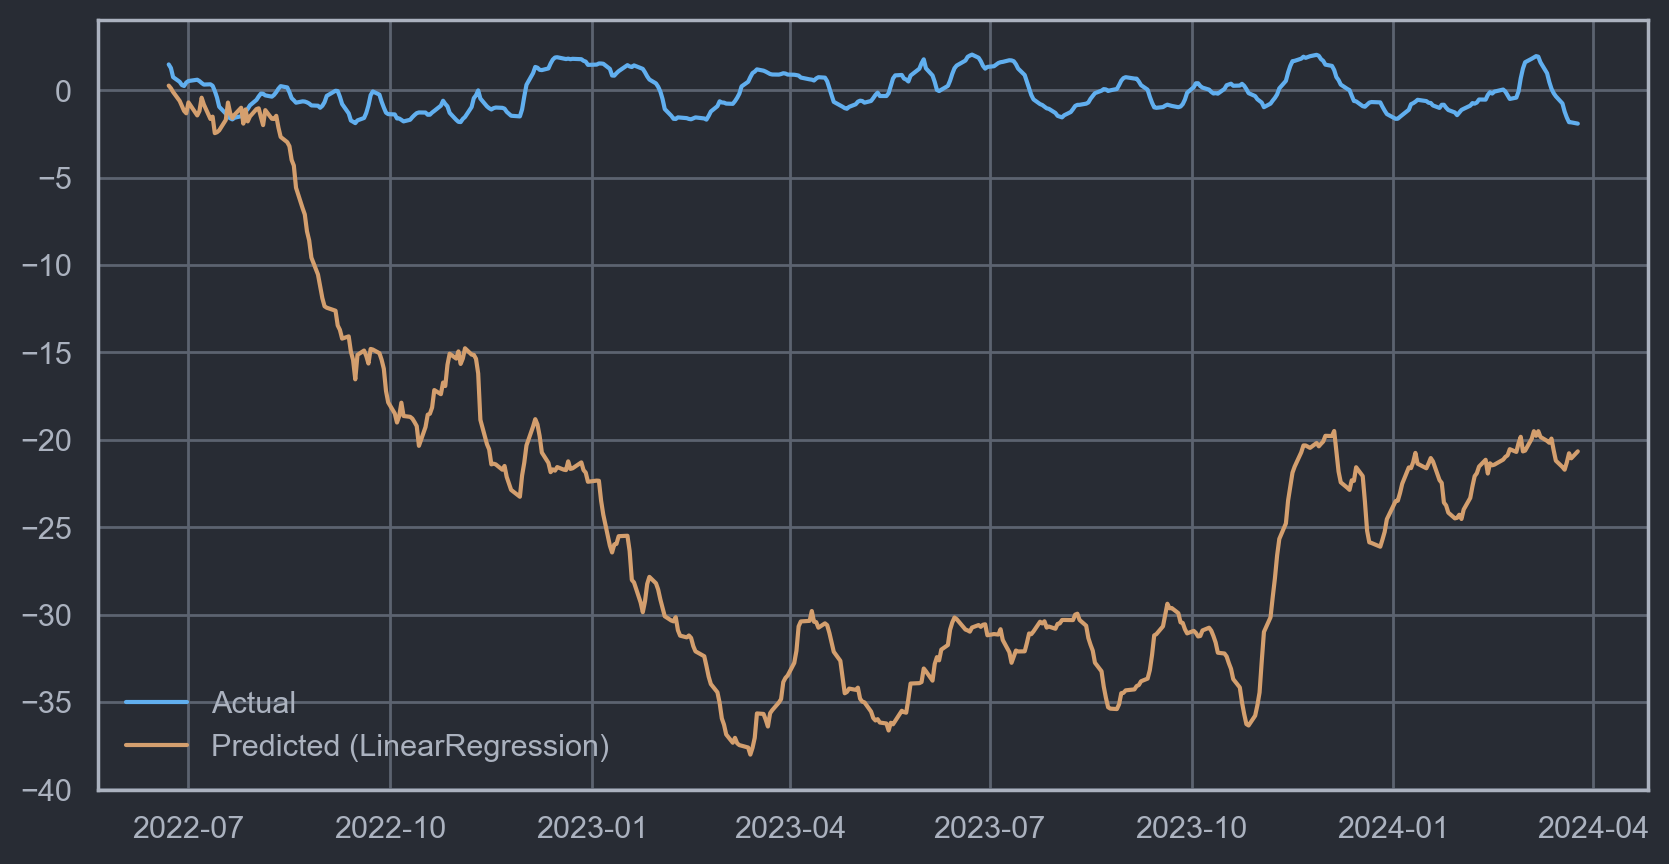


KNeighborsRegressor

R2: -0.06, MAE: 0.91, MSE: 1.18, RMSE: 1.09


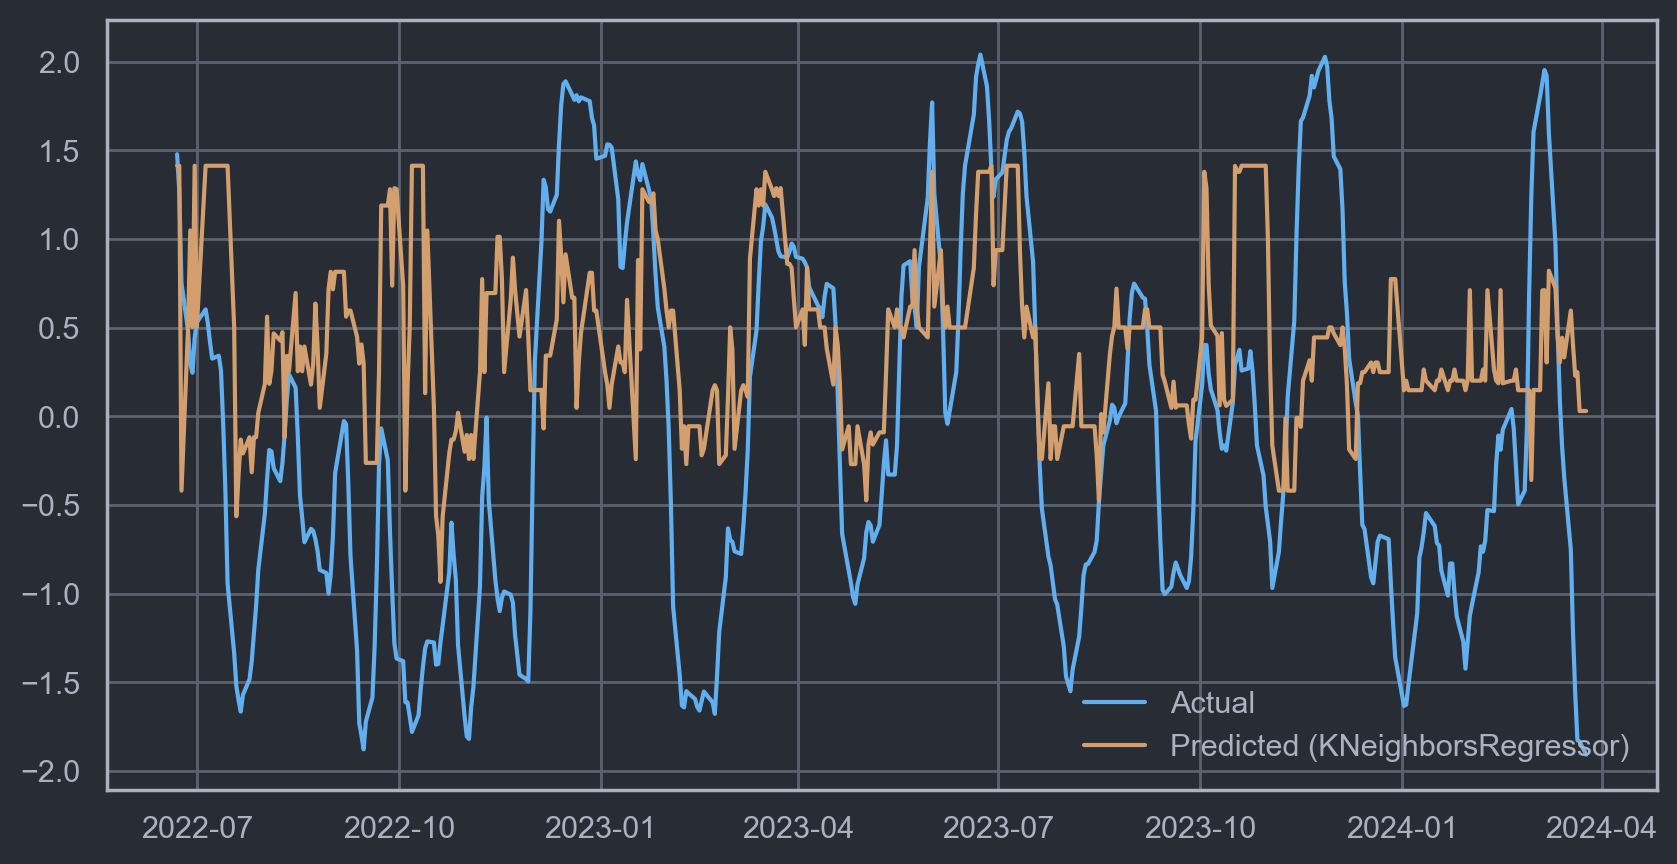


GradientBoostingRegressor

R2: 0.56, MAE: 0.58, MSE: 0.50, RMSE: 0.70


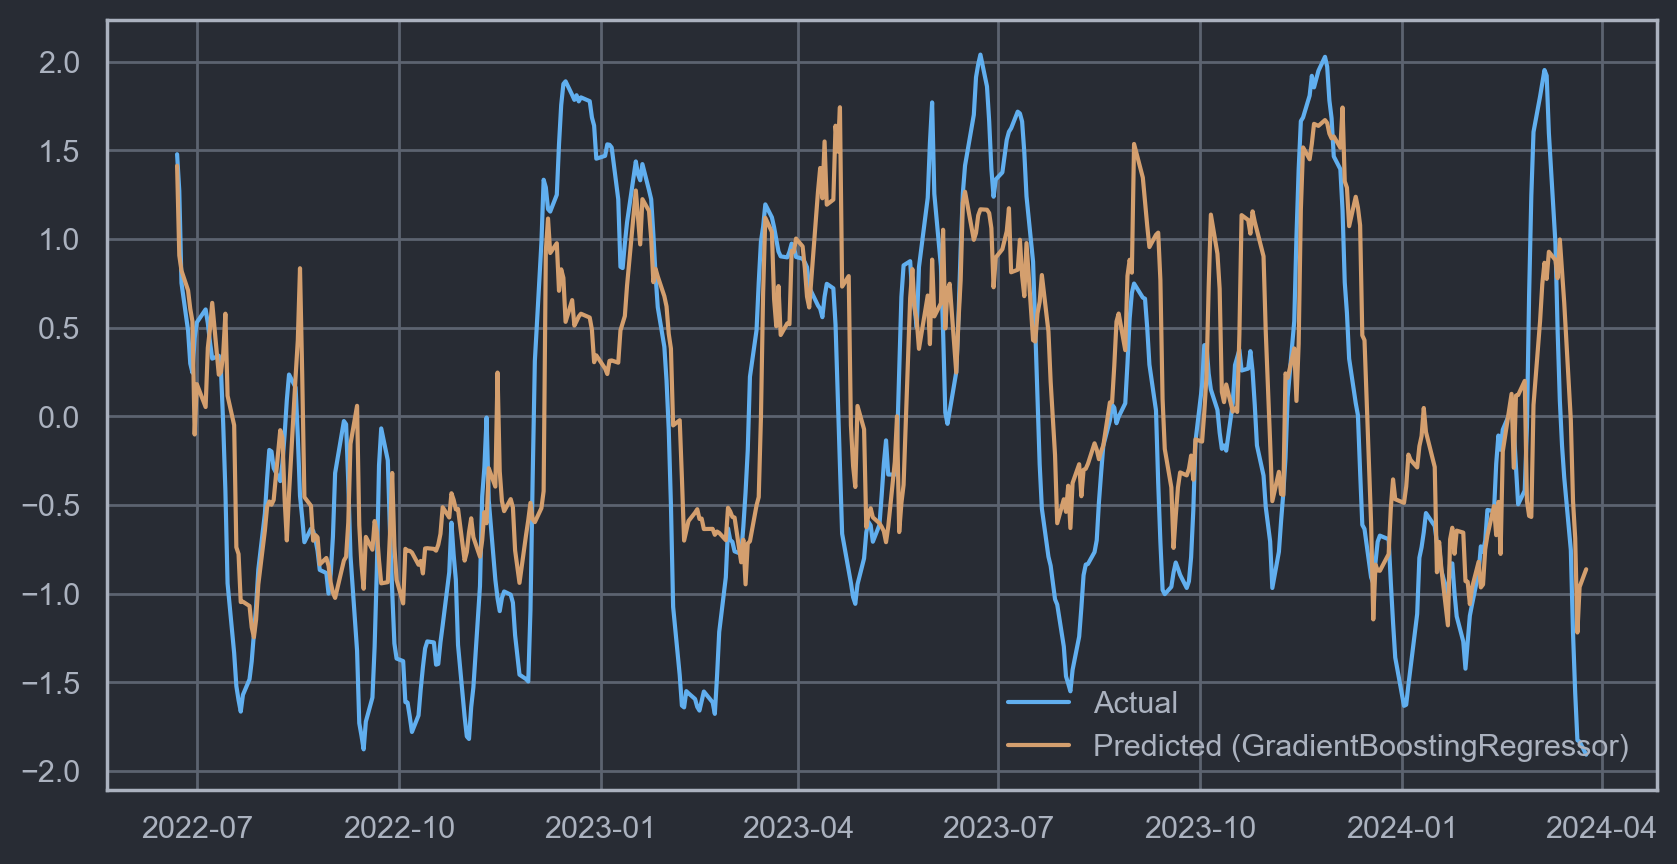


RandomForestRegressor

R2: 0.60, MAE: 0.53, MSE: 0.45, RMSE: 0.67


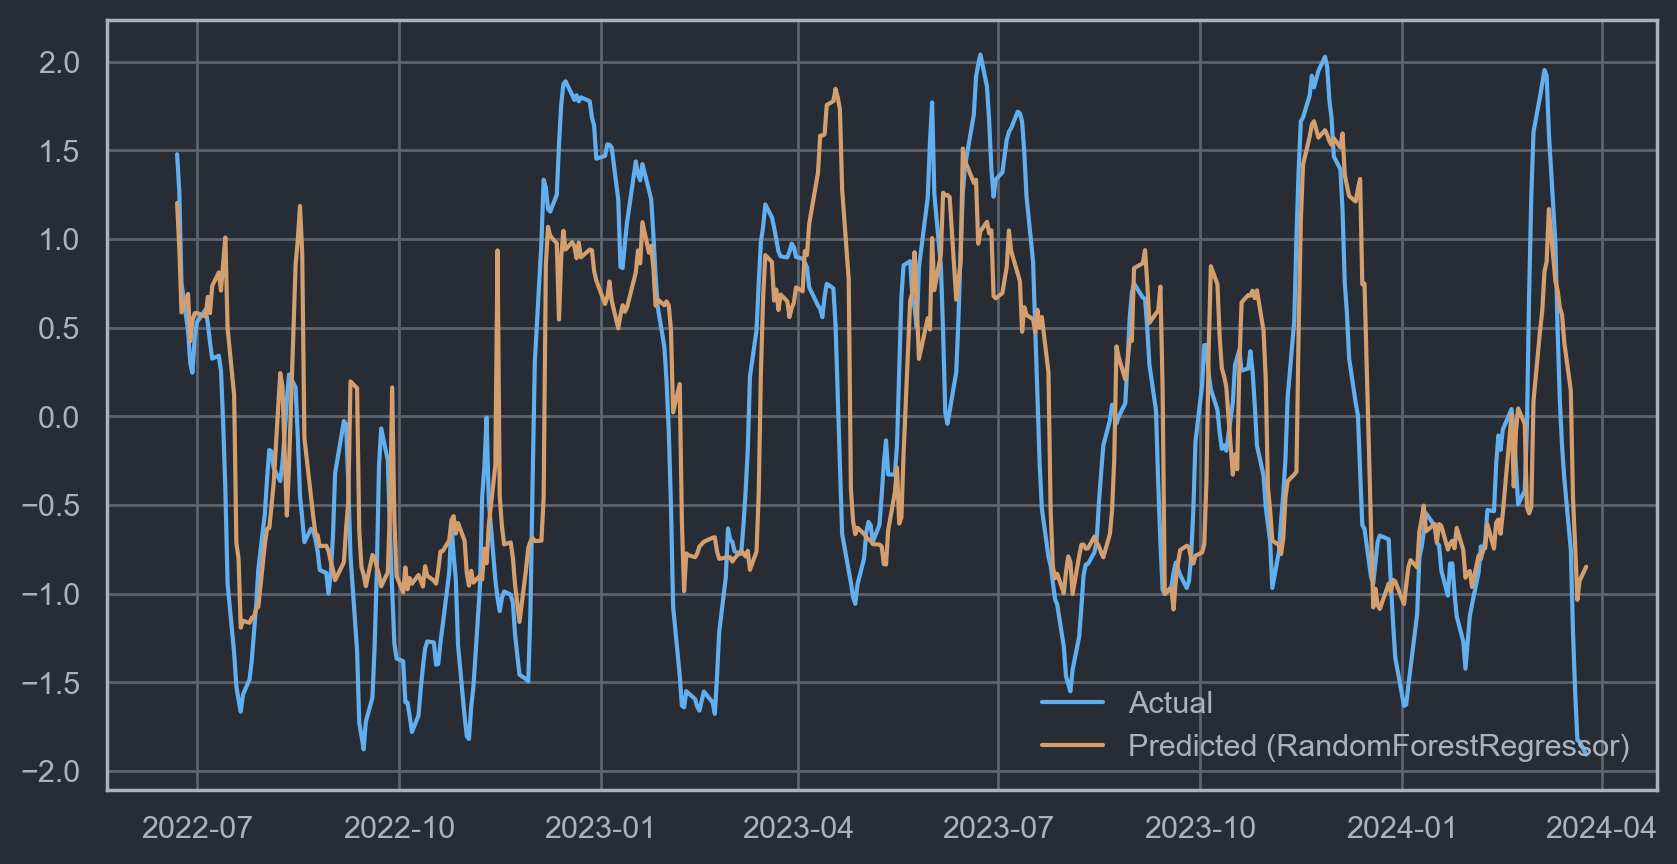


LGBMRegressor

R2: 0.57, MAE: 0.55, MSE: 0.48, RMSE: 0.69


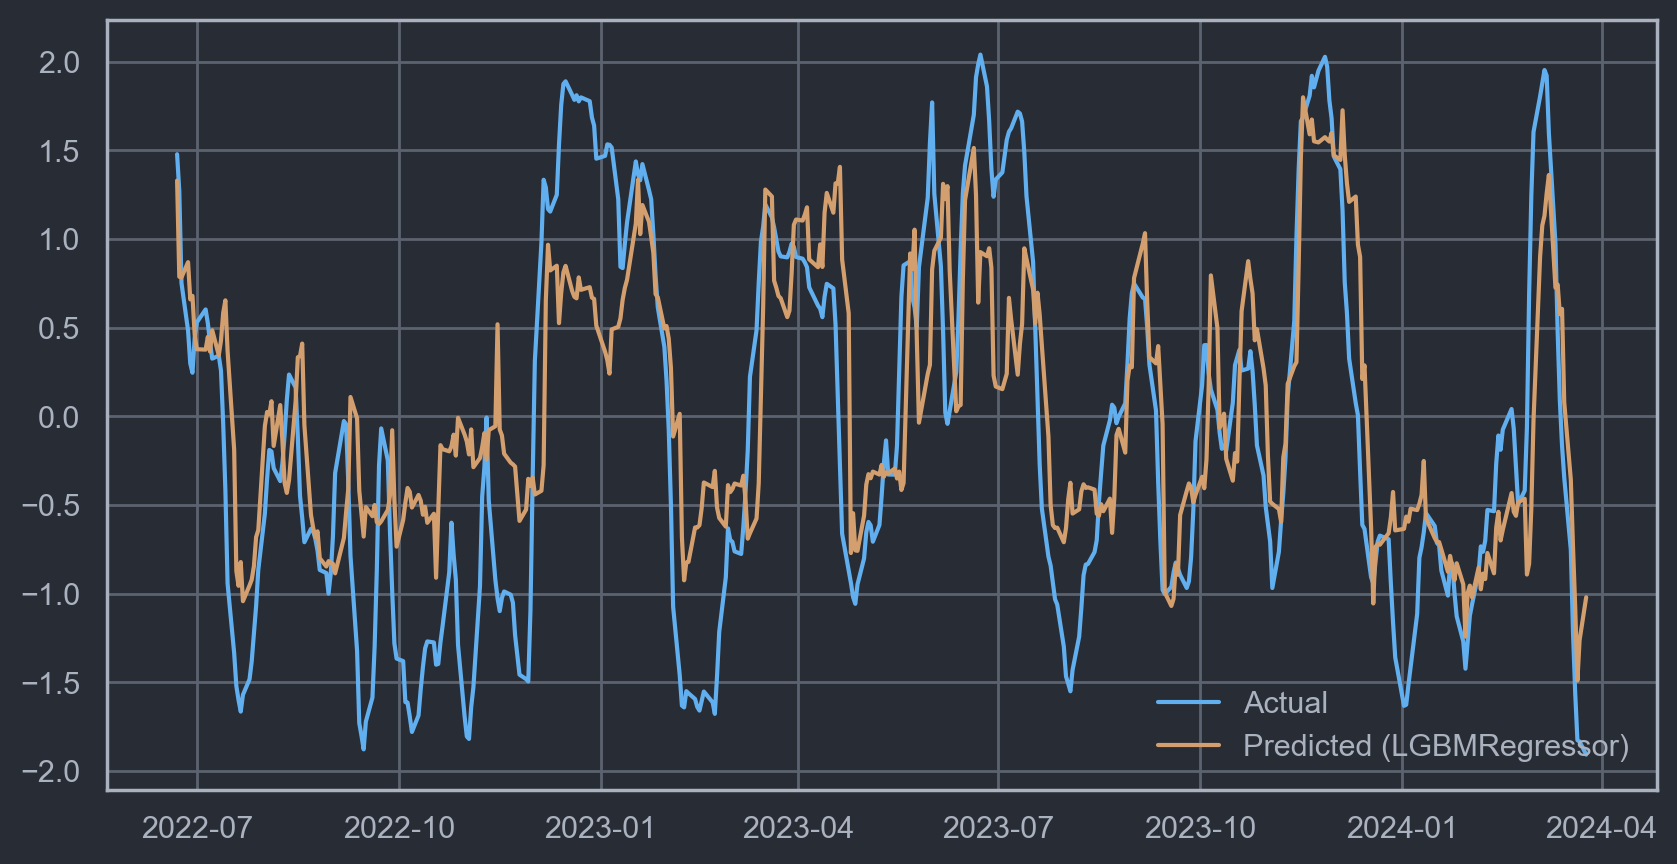

High_S1  Low_S1  Open_S1  Volume_S1  Adj Close_S1        P_S1  \
Date                                                                         
2021-01-04  267.5800  260.16   267.00  3572043.0        265.00  264.246667   
2021-01-05  273.5000  262.57   263.88  4207081.0        270.93  269.000000   
2021-01-06  288.3800  273.10   276.29  6383530.0        285.55  282.343333   
2021-01-07  295.8894  286.68   287.77  4009730.0        291.65  291.406467   
2021-01-08  292.2800  285.06   292.00  2800784.0        290.08  289.140000   
...              ...     ...      ...        ...           ...         ...   
2024-03-25  410.4600  403.86   406.87  1683977.0        404.94  406.420000   
2024-03-26  409.3300  404.52   406.09  1406974.0        406.18  406.676667   
2024-03-27  415.4900  408.37   409.62  2353629.0        415.25  413.036667   
2024-03-28  419.2000  414.98   416.21  2409718.0        417.69  417.290000   
2024-04-01  417.9500  412.00   416.68  1863918.0        413.51  414.486667   

                 R1_S1       R2_S1       R3_S1       S1_S1  ...  \
Date                                                        ...   
2021-01-04  267.081107  268.832227  271.666667  261.412227  ...   
2021-01-05  273.175260  275.754740  279.930000  264.824740  ...   
2021-01-06  288.180293  291.786373  297.623333  276.506373  ...   
2021-01-07  294.924457  297.097876  300.615867  287.888476  ...   
2021-01-08  291.898040  293.601960  296.360000  286.381960  ...   
...                ...         ...         ...         ...  ...   
2024-03-25  408.941200  410.498800  413.020000  403.898800  ...   
2024-03-26  408.514087  409.649247  411.486667  404.839247  ...   
2024-03-27  415.756507  417.436827  420.156667  410.316827  ...   
2024-03-28  418.902040  419.897960  421.510000  415.677960  ...   
2024-04-01  416.759567  418.163767  420.436667  412.213767  ...   

            twitter_pos_sentiment_count_S2_ma40  \
Date                                              
2021-01-04                                  NaN   
2021-01-05                                  NaN   
2021-01-06                                  NaN   
2021-01-07                                  NaN   
2021-01-08                                  NaN   
...                                         ...   
2024-03-25                               36.000   
2024-03-26                               35.100   
2024-03-27                               35.025   
2024-03-28                               36.800   
2024-04-01                                  NaN   

            news_pos_sentiment_count_S2_ma40  \
Date                                           
2021-01-04                               NaN   
2021-01-05                               NaN   
2021-01-06                               NaN   
2021-01-07                               NaN   
2021-01-08                               NaN   
...                                      ...   
2024-03-25                             0.900   
2024-03-26                             0.850   
2024-03-27                             0.900   
2024-03-28                             0.925   
2024-04-01                               NaN   

            news_pos_sentiment_count_S1_ma80  \
Date                                           
2021-01-04                               NaN   
2021-01-05                               NaN   
2021-01-06                               NaN   
2021-01-07                               NaN   
2021-01-08                               NaN   
...                                      ...   
2024-03-25                            2.4125   
2024-03-26                            2.4000   
2024-03-27                            2.3875   
2024-03-28                            2.4000   
2024-04-01                               NaN   

            news_sentiment_daily_avg_S1_ma80  \
Date                                           
2021-01-04                               NaN   
2021-01-05                               NaN   
2021-01-06          

In [244]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')   
plt.style.use('custom_onedark')

data_dir = '../data/'
price_history_dir = data_dir + f'{data_dir}price_history/'
sentiment_dir = data_dir + f'{data_dir}sentiments/'
ti_dir = data_dir + f'{data_dir}technical_indicators/'

import glob

# Load Ticker Pairs
tickers_list = [file.split('/')[-1].strip('.csv') for file in glob.glob(price_history_dir + '*.csv')]
pairs_df = pd.read_csv(data_dir + 'ranked_pairs_snp.csv')
pairs = pairs_df[['ticker_0', 'ticker_1']].values
unique_pairs= pairs_df[['ticker_0', 'ticker_1']].drop_duplicates('ticker_0', keep='first').drop_duplicates('ticker_1', keep='first')


# Load Ticker History, Sentiment and Technical Indicators
data = {}
class TickerData:
    def __init__(self, ticker):
        self.ticker = ticker
        self.history = pd.read_csv(price_history_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
        self.sentiment = pd.read_csv(sentiment_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
        self.ti = pd.read_csv(ti_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
    def __repr__(self):
        return repr(self.history['Adj Close'])

class DATA:
    pass

for ticker in tickers_list:
    setattr(DATA, ticker, TickerData(ticker))

    data[ticker] = TickerData(ticker)

# Pair Selection
PAIR_IDX = 0
ADD_SENTIMENT_MA = True

pair = pairs[PAIR_IDX]
print(pair)

# Join Sentiment and add Sentiment Moving Averages if ADD_SENTIMENT_MA is True
pair_sentiment_df = pd.merge( data[pair[0]].sentiment, data[pair[1]].sentiment, left_index=True, right_index=True, suffixes=("_S1", "_S2"),)
if ADD_SENTIMENT_MA:
    pair_sentiment_df = add_moving_averages(pair_sentiment_df, [5, 10, 20, 40, 80], columns=pair_sentiment_df.columns)

# Join Technical Indicators
pair_ti_df = pd.merge( data[pair[0]].ti, data[pair[1]].ti, left_index=True, right_index=True, suffixes=("_S1", "_S2"))
pair_df = pd.merge(pair_ti_df, pair_sentiment_df, left_index=True, right_index=True, how="left")


# ---- Dataset Setup ----
# We want to predict the z-score of spread, to forecast deviations from the mean

# The Z-score of the spread will be used to determine when to buy and sell
# We use a low/high moving average to calculate the z-score. 
# This is so that the z-score is not affected by the spread increasing over time
# Can play around with the window sizes to see what works best

SPREAD_WINDOW = None
MA_HIGH = 45
MA_LOW = 4

# Parameters
LOOK_BACK = 3
DROP_COLS = [

]
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

def calculate_metrics(y_true, y_pred):
    metric_frame = {
        "r2": r2_score(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "mse": mean_squared_error(y_true, y_pred),
        "rmse": np.sqrt(mean_squared_error(y_true, y_pred)),
    }
    print(f"\nR2: {metric_frame['r2']:.2f}, MAE: {metric_frame['mae']:.2f}, MSE: {metric_frame['mse']:.2f}, RMSE: {metric_frame['rmse']:.2f}")
    return metric_frame


spread = get_spread(pair_df['Adj Close_S1'], pair_df['Adj Close_S2'], window=SPREAD_WINDOW)
pair_df['spread'] = spread

# Calculate Moving Z score Calculation (Trading Signal)
ma_high = pair_df.spread.rolling(window=MA_HIGH).mean()
ma_low = pair_df.spread.rolling(window=MA_LOW).mean()
std_high = pair_df.spread.rolling(window=MA_HIGH).std()

moving_zscore = (ma_low - ma_high) / std_high
pair_df['zscore_spread'] = moving_zscore


train_data, val_data, test_data = create_dataset(
    pair_df, 
    look_back=LOOK_BACK, 
    target_col="zscore_spread", 
    drop_cols=DROP_COLS
)

X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)

X_test = pd.concat([X_val, X_test])
y_test = pd.concat([y_val, y_test])





def train(model, X_train, y_train, X_test, y_test, model_results, plot=True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model_name = model.__class__.__name__
    print(f"\n{model_name}")
    model_results[model_name] = {
        'metrics': calculate_metrics(y_test, y_pred),
        'model': model,
        'data': (X_train, y_train, X_test, y_test)
    }

    if plot:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(y_test.index, y_test, label="Actual")
        ax.plot(y_test.index, y_pred, label=f"Predicted ({model_name})")
        ax.legend()
        plt.show()



base_models = [
    LinearRegression(),
    # KNeighborsRegressor(),
    GradientBoostingRegressor(random_state=42),
    RandomForestRegressor(n_estimators=100, random_state=42),
    LGBMRegressor(random_state=42, verbose=-1),
]

for model in base_models:
    train(model, X_train, y_train, X_test, y_test, model_results, plot=True)

pair_df

### Benchmark Gradient Boosting Regressor Model


R2: 0.56, MAE: 0.58, MSE: 0.49, RMSE: 0.70


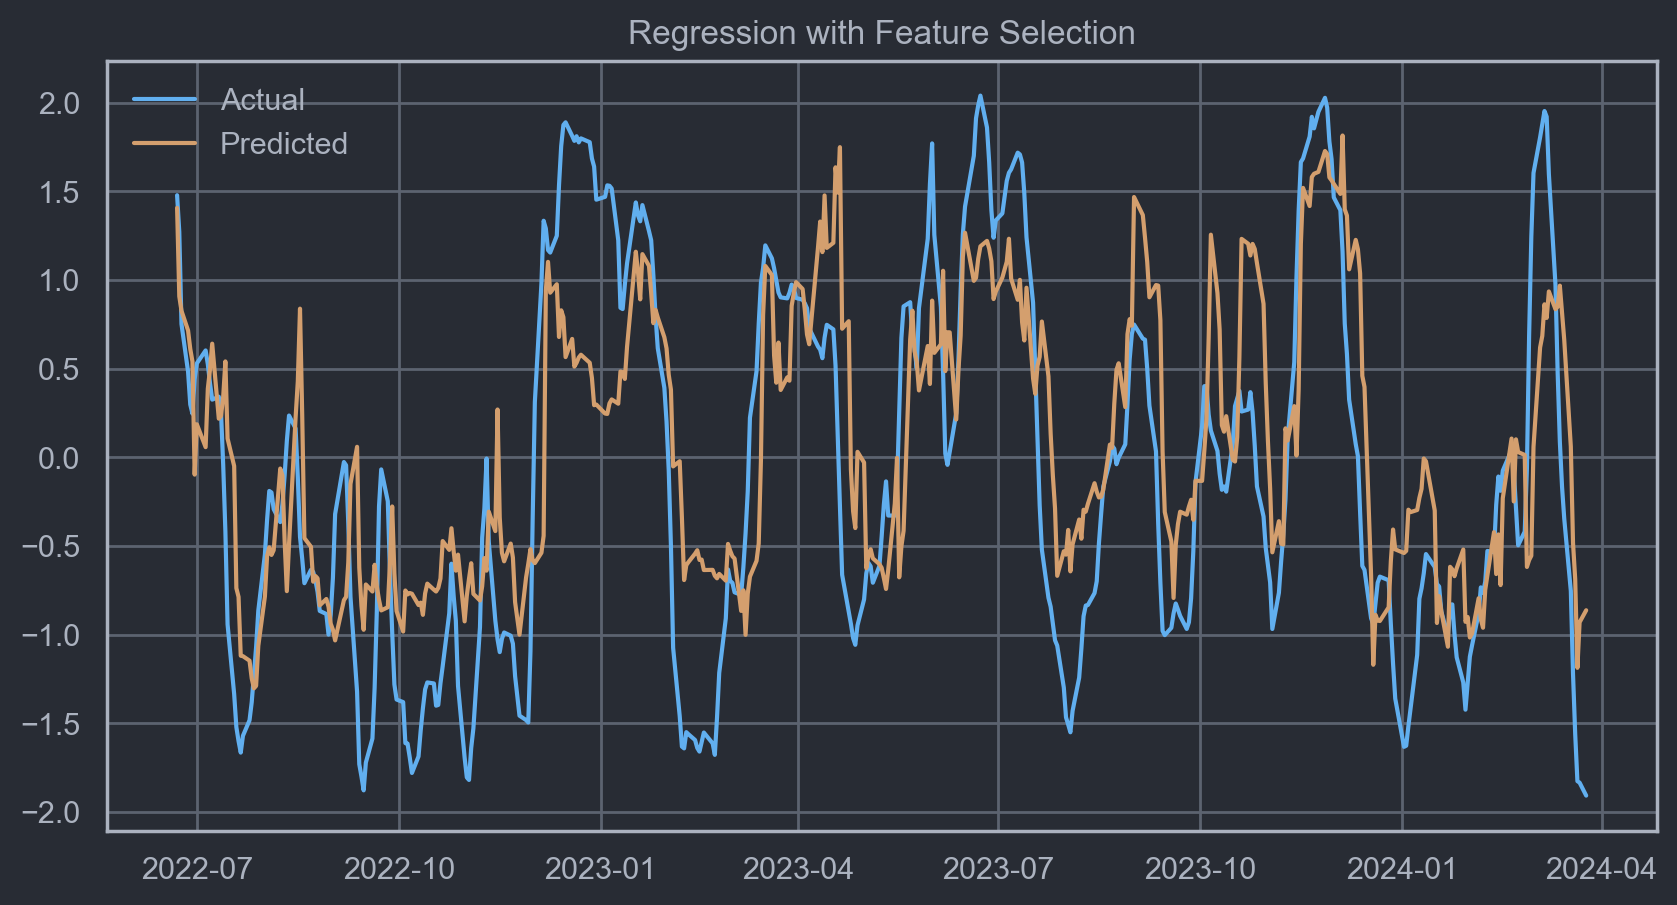

In [245]:
model_reg = GradientBoostingRegressor()
model_reg.fit(X_train, y_train)

y_pred = model_reg.predict(X_test)


model_results['Regression with Feature Selection'] = calculate_metrics(y_test, y_pred)

fig = plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.title('Regression with Feature Selection')
plt.legend()

plt.show()


### LSTM and BiLSTM

In [322]:
import tensorflow as tf
keras = tf.keras

from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Dropout
from keras.models import save_model, load_model
from keras.callbacks import EarlyStopping, History, ModelCheckpoint, CSVLogger
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler


model_results2 = {}

# Prepare and scale the data
X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

def calculate_padding(features, look_back):
    return (look_back - (features % look_back)) % look_back

# Pad and reshape data for LSTM
padding_train = calculate_padding(X_train.shape[1], LOOK_BACK)
padding_val = calculate_padding(X_val.shape[1], LOOK_BACK)
padding_test = calculate_padding(X_test.shape[1], LOOK_BACK)

X_train_padded = np.pad(X_train, ((0, 0), (0, padding_train)), 'constant', constant_values=0)
X_val_padded = np.pad(X_val, ((0, 0), (0, padding_val)), 'constant', constant_values=0)
X_test_padded = np.pad(X_test, ((0, 0), (0, padding_test)), 'constant', constant_values=0)

X_train_lstm = X_train_padded.reshape((X_train.shape[0], LOOK_BACK, -1))
X_val_lstm = X_val_padded.reshape((X_val.shape[0], LOOK_BACK, -1))
X_test_lstm = X_test_padded.reshape((X_test.shape[0], LOOK_BACK, -1))



# Constants and callbacks
LR = 0.001
EPOCHS = 100
BATCH_SIZE = 16

lstm_csv_logger = CSVLogger('lstm_training.csv')
bilstm_csv_logger = CSVLogger('bilstm_training.csv')

model_checkpoint_lstm = ModelCheckpoint('best_model_lstm.keras', monitor='val_loss', mode='min')
model_checkpoint_bilstm = ModelCheckpoint('best_model_bilstm.keras', monitor='val_loss', mode='min')

# Vanilla LSTM model
model_vanilla_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    LSTM(50),
    Dense(1)
])

optimizer = Adam(learning_rate=LR)
early_stopping = EarlyStopping(monitor='val_loss', patience=6)
history_vanilla_lstm = History()

model_vanilla_lstm.compile(optimizer=optimizer, loss='mae', metrics=['mae', 'mse'])
model_vanilla_lstm.fit(X_train_lstm, y_train, epochs=EPOCHS, validation_data=(X_val_lstm, y_val), verbose=1,
                       callbacks=[early_stopping, history_vanilla_lstm], batch_size=BATCH_SIZE)

y_pred_vanilla_lstm = model_vanilla_lstm.predict(X_test_lstm)
model_results2['Vanilla LSTM'] = {
    'metrics': calculate_metrics(y_test, y_pred_vanilla_lstm.flatten()),
    'model': model_vanilla_lstm,
    'data': (X_train_lstm, y_train, X_test_lstm, y_test)
}

# LSTM model
model_lstm = Sequential([
    LSTM(200, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.3),
    LSTM(200, return_sequences=True),
    Dropout(0.3),
    LSTM(100),
    Dropout(0.3),
    Dense(100, activation='relu'),
    Dense(1, activation='linear')
])

optimizer = Adam(learning_rate=LR)
early_stopping = EarlyStopping(monitor='val_loss', patience=6)
history_lstm = History()

model_lstm.compile(optimizer=optimizer, loss='mae', metrics=['mae', 'mse'])
model_lstm.fit(X_train_lstm, y_train, epochs=EPOCHS, validation_data=(X_val_lstm, y_val), verbose=1,
               callbacks=[early_stopping, history_lstm, lstm_csv_logger, model_checkpoint_lstm],
               batch_size=BATCH_SIZE)

y_pred_lstm = model_lstm.predict(X_test_lstm)
model_results2['LSTM'] = {
    'metrics': calculate_metrics(y_test, y_pred_lstm.flatten()),
    'model': model_lstm,
    'data': (X_train_lstm, y_train, X_test_lstm, y_test)
}

# BiLSTM model
model_bilstm = Sequential([
    Bidirectional(LSTM(100, return_sequences=True), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(100, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(50)),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)
])

optimizer = Adam(learning_rate=LR)
early_stopping = EarlyStopping(monitor='val_loss', patience=6)
history_bilstm = History()

model_bilstm.compile(optimizer=optimizer, loss='mae', metrics=['mae', 'mse'])
model_bilstm.fit(X_train_lstm, y_train, epochs=EPOCHS, validation_data=(X_val_lstm, y_val), verbose=1,
                 callbacks=[early_stopping, history_bilstm, bilstm_csv_logger, model_checkpoint_bilstm],
                 batch_size=BATCH_SIZE)

y_pred_bilstm = model_bilstm.predict(X_test_lstm)
model_results2['BiLSTM with Dropout'] = {
    'metrics': calculate_metrics(y_test, y_pred_bilstm.flatten()),
    'model': model_bilstm,
    'data': (X_train_lstm, y_train, X_test_lstm, y_test)
}

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 906ms/step - loss: 0.8505 - mae: 0.8511 - mse: 1.0424 - val_loss: 0.6451 - val_mae: 0.6741 - val_mse: 0.6865
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - loss: 0.6715 - mae: 0.6714 - mse: 0.7847 - val_loss: 0.7108 - val_mae: 0.7556 - val_mse: 0.7878
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.4523 - mae: 0.4521 - mse: 0.3800 - val_loss: 0.8523 - val_mae: 0.8719 - val_mse: 1.0082
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.3371 - mae: 0.3371 - mse: 0.2098 - val_loss: 0.7769 - val_mae: 0.7855 - val_mse: 0.8073
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.2851 - mae: 0.2848 - mse: 0.1571 - val_loss: 0.8082 - val_mae: 0.8032 - val_mse: 0.8633
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.2536 - mae: 0.2536 - mse: 0.1136 - val_loss: 0.7795 - val_mae: 0.7765 - val_mse: 0.7986
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.2237 - mae: 0.2238 - mse: 0.0965 -

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 796ms/step - loss: 0.9575 - mae: 0.9592 - mse: 1.3235 - val_loss: 0.6819 - val_mae: 0.7112 - val_mse: 0.6989
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - loss: 0.6677 - mae: 0.6681 - mse: 0.8020 - val_loss: 0.7668 - val_mae: 0.8081 - val_mse: 0.9557
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.4127 - mae: 0.4131 - mse: 0.3335 - val_loss: 0.8729 - val_mae: 0.8838 - val_mse: 1.0266
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3120 - mae: 0.3120 - mse: 0.1970 - val_loss: 0.7101 - val_mae: 0.7584 - val_mse: 0.7580
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.2926 - mae: 0.2930 - mse: 0.1636 - val_loss: 0.7544 - val_mae: 0.7765 - val_mse: 0.8116
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.2234 - mae: 0.2231 - mse: 0.0916 - val_loss: 0.8424 - val_mae: 0.8511 - val_mse: 0.9738
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.2236 - mae: 0.2236 - mse: 0.0995 - 

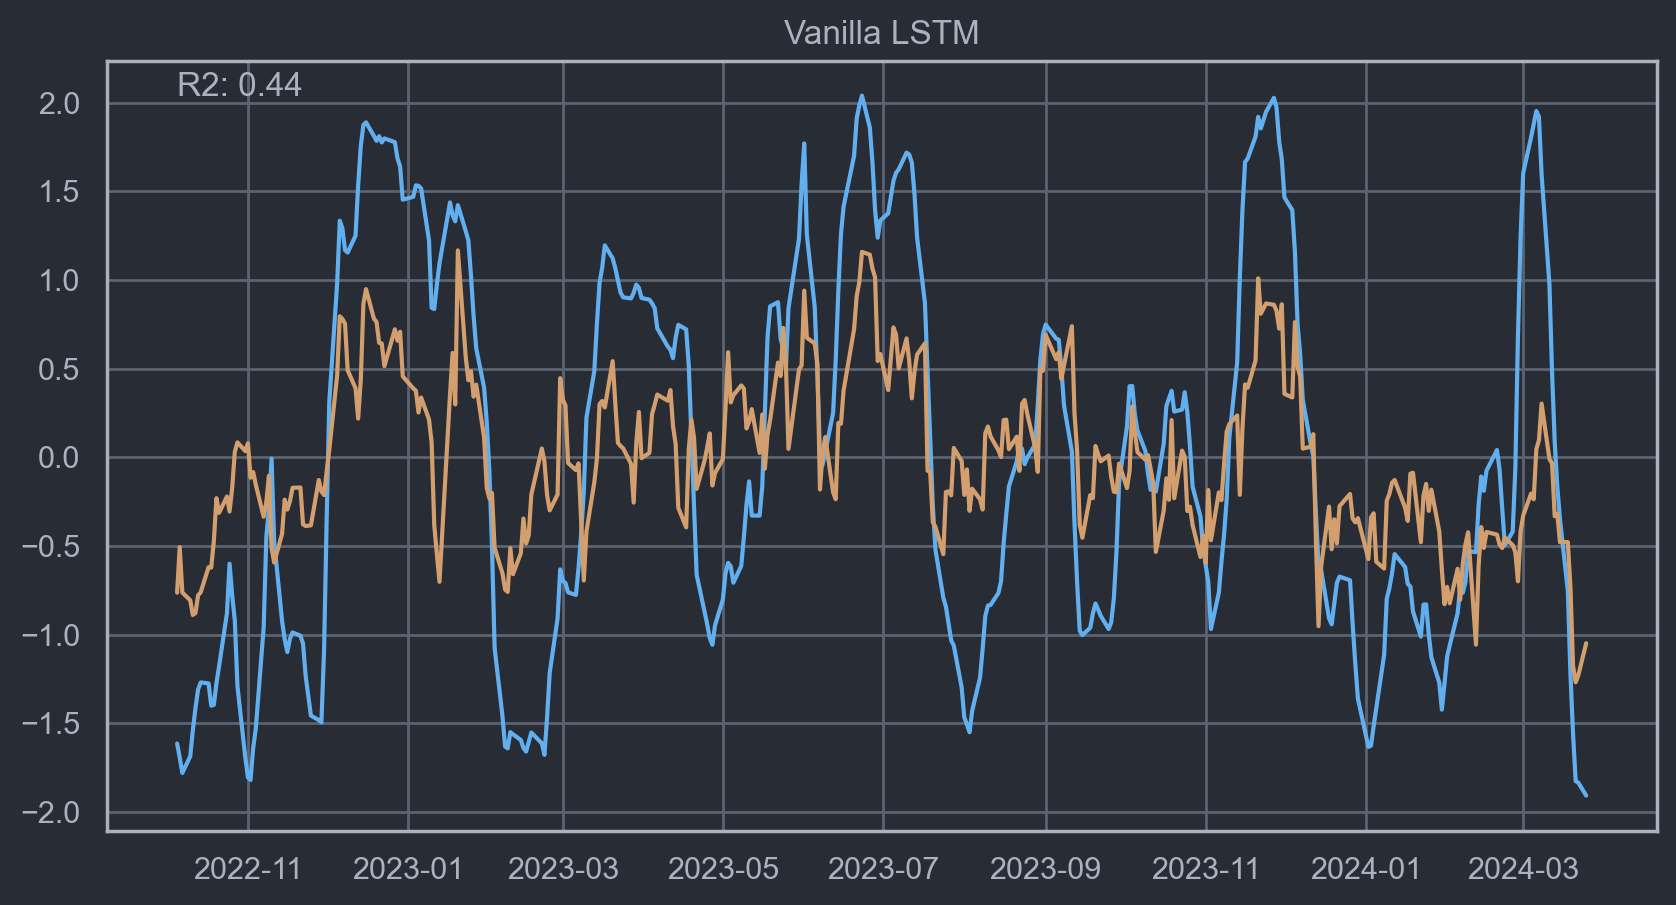

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - loss: 0.9316 - mae: 0.9305 - mse: 1.2083 - val_loss: 0.6861 - val_mae: 0.7120 - val_mse: 0.7947
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - loss: 0.6665 - mae: 0.6664 - mse: 0.7700 - val_loss: 0.7558 - val_mae: 0.7955 - val_mse: 0.8413
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 0.4075 - mae: 0.4078 - mse: 0.2898 - val_loss: 0.6393 - val_mae: 0.6709 - val_mse: 0.5788
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.4135 - mae: 0.4133 - mse: 0.2733 - val_loss: 0.5498 - val_mae: 0.5732 - val_mse: 0.4296
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.3366 - mae: 0.3368 - mse: 0.1982 - val_loss: 0.5827 - val_mae: 0.5973 - val_mse: 0.5140
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.3115 - mae: 0.3114 - mse: 0.1702 - val_loss: 0.6527 - val_mae: 0.6542 - val_mse: 0.6067
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.3267 - mae: 0.3270 - mse: 0.1948 - v

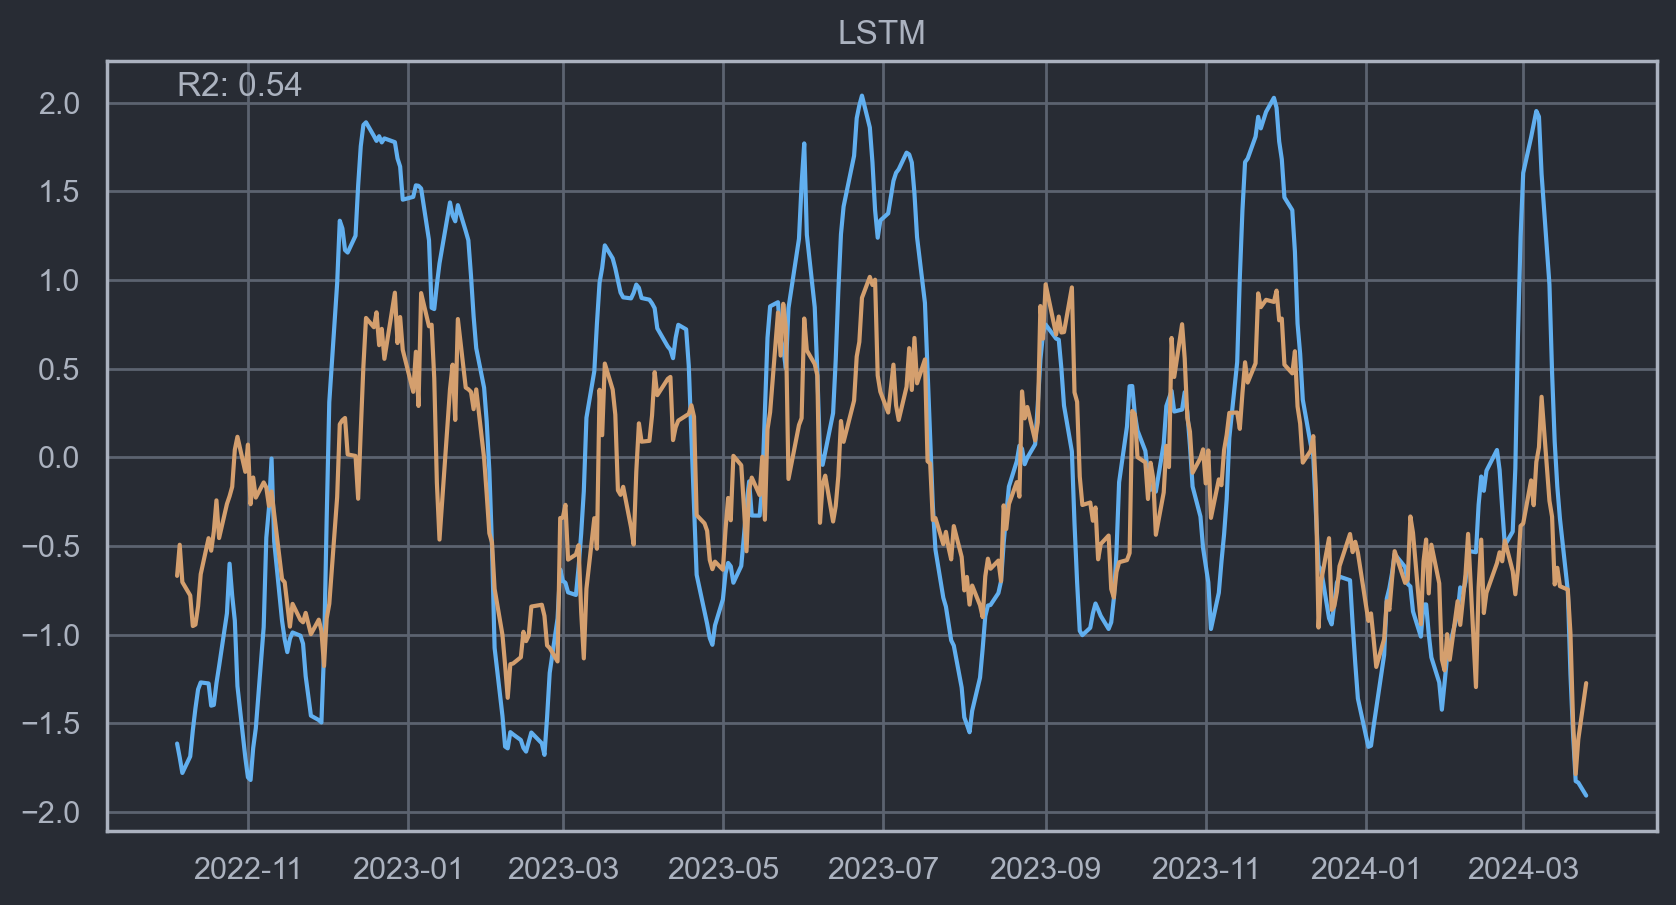

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - loss: 0.8618 - mae: 0.8624 - mse: 1.0873 - val_loss: 0.7065 - val_mae: 0.7392 - val_mse: 0.8032
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 596ms/step - loss: 0.4938 - mae: 0.4939 - mse: 0.4004 - val_loss: 0.7560 - val_mae: 0.7702 - val_mse: 0.8054
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 254ms/step - loss: 0.3520 - mae: 0.3518 - mse: 0.2132 - val_loss: 0.8414 - val_mae: 0.8574 - val_mse: 0.9954
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - loss: 0.3074 - mae: 0.3075 - mse: 0.1767 - val_loss: 0.5802 - val_mae: 0.5928 - val_mse: 0.4805
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - loss: 0.2541 - mae: 0.2539 - mse: 0.1211 - val_loss: 0.8153 - val_mae: 0.8343 - val_mse: 0.9127
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.2361 - mae: 0.2364 - mse: 0.0999 - val_loss: 0.8385 - val_mae: 0.8534 - val_mse: 0.9493
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - loss: 0.2429 - mae: 0.2431 - mse: 0.1019

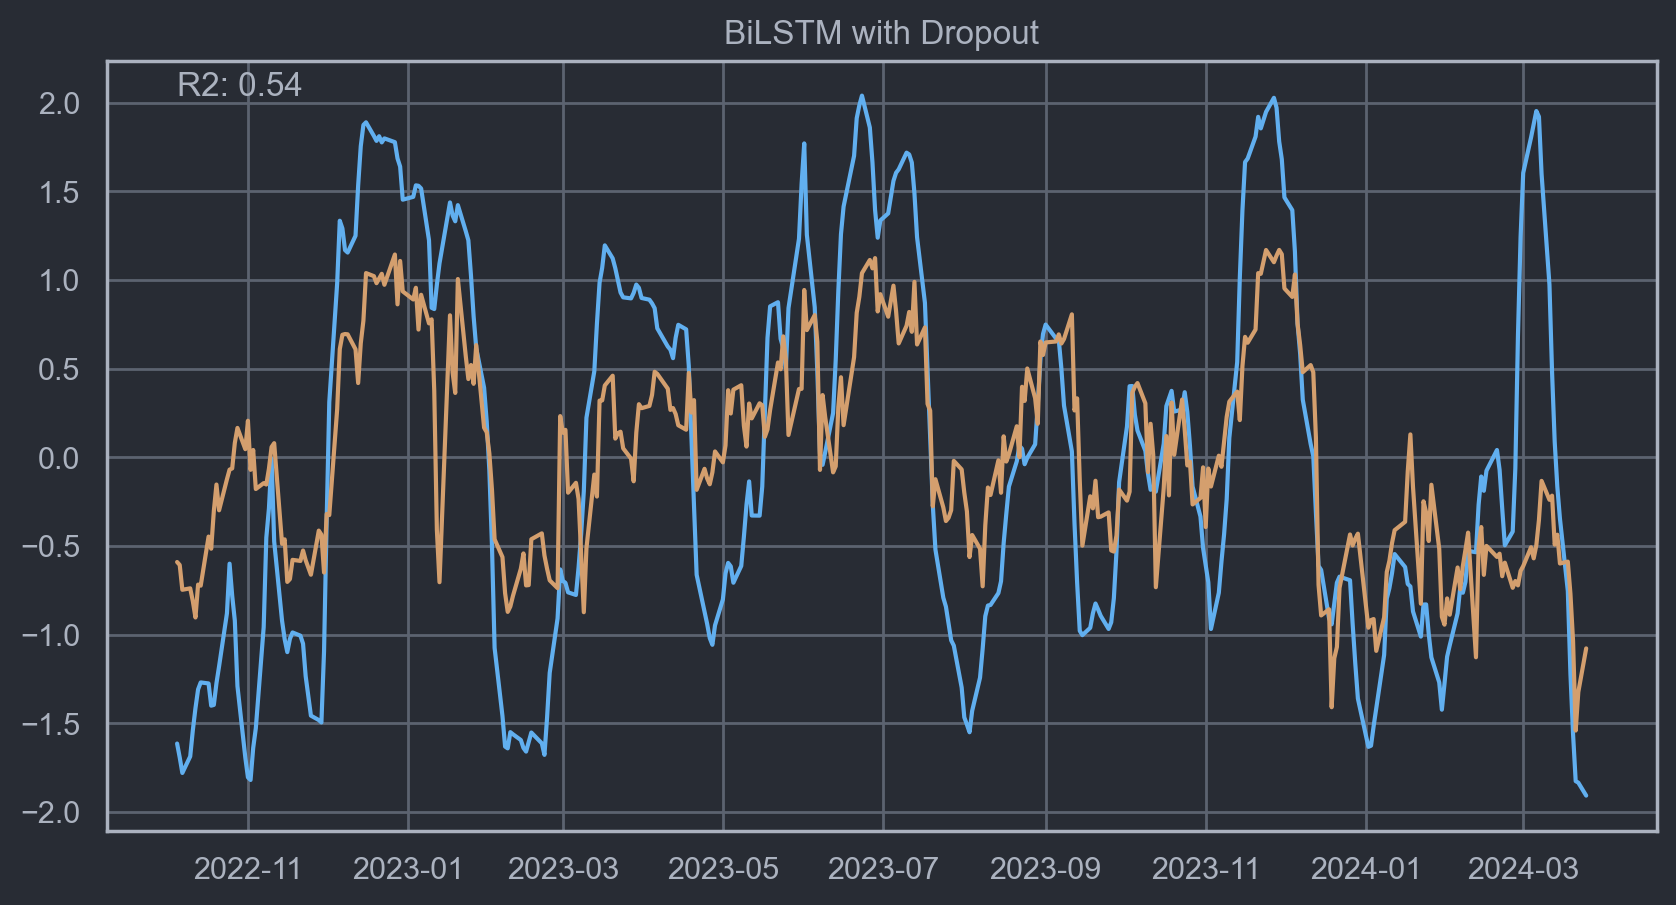

In [250]:
import tensorflow as tf
keras = tf.keras

from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Dropout, Flatten
from keras.models import Sequential, save_model, load_model
from keras.callbacks import EarlyStopping, History, ModelCheckpoint
from keras.optimizers import Adam



X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)

# Scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


def calculate_padding(features, look_back):
    return (look_back - (features % look_back)) % look_back

padding_train = calculate_padding(X_train.shape[1], LOOK_BACK)
padding_val = calculate_padding(X_val.shape[1], LOOK_BACK)
padding_test = calculate_padding(X_test.shape[1], LOOK_BACK)

# Pad training, validation and testing feature sets
X_train_padded = np.pad(X_train,  ((0, 0), (0, padding_train)), 'constant', constant_values=0)
X_val_padded = np.pad(X_val,  ((0, 0), (0, padding_val)), 'constant', constant_values=0)
X_test_padded = np.pad(X_test,  ((0, 0), (0, padding_test)), 'constant', constant_values=0)

# Reshape all sets for LSTM
X_train_lstm = X_train_padded.reshape((X_train.shape[0], LOOK_BACK, -1))
X_val_lstm = X_val_padded.reshape((X_val.shape[0], LOOK_BACK, -1))
X_test_lstm = X_test_padded.reshape((X_test.shape[0], LOOK_BACK, -1))


from keras.callbacks import CSVLogger, ModelCheckpoint

LR = 0.001
EPOCHS = 100
BATCH_SIZE = 16



# CSVLogger callback
lstm_csv_logger = CSVLogger('lstm_training.csv')
bilstm_csv_logger = CSVLogger('bilstm_training.csv')


# ModelCheckpoint callback
model_checkpoint_lstm = ModelCheckpoint('best_model_lstm.keras',            
                                        # save_best_only=True,
                                         monitor='val_loss', mode='min')
model_checkpoint_bilstm = ModelCheckpoint('best_model_bilstm.keras',        
                                          # save_best_only=True,
                                           monitor='val_loss', mode='min')



# Build the LSTM model
model_vanilla_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    LSTM(50),
    Dense(1)
])

optimizer = Adam(learning_rate=LR)

early_stopping = EarlyStopping(monitor='val_loss', patience=6)
history_vanilla_lstm = History()

model_vanilla_lstm.compile(optimizer=optimizer, loss='mae', metrics=['mae', 'mse'])

# Fit the model
model_vanilla_lstm.fit(X_train_lstm, y_train, epochs=EPOCHS, validation_data=(X_val_lstm, y_val), verbose=1, callbacks=[early_stopping, history_vanilla_lstm], batch_size=BATCH_SIZE)

# Predict
y_pred_vanilla_lstm = model_vanilla_lstm.predict(X_test_lstm)

# Evaluate
model_results['Vanilla LSTM'] = {
    'metrics': calculate_metrics(y_test, y_pred_vanilla_lstm.flatten()),
    'model': model_vanilla_lstm,
    'data': (X_train_lstm, y_train, X_test_lstm, y_test)
}

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred_vanilla_lstm.flatten(), label="Predicted Vanilla LSTM")
plt.title('Vanilla LSTM')
# Add R2 Score to Plot
plt.text(y_test.index[0], y_test.max(), f"R2: {model_results['Vanilla LSTM']['metrics']['r2']:.2f}", fontsize=12)
plt.show()




model_lstm = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)
])
model_lstm = Sequential([
    LSTM(200, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.3),
    LSTM(200, return_sequences=True),
    Dropout(0.3),
    LSTM(100),
    Dropout(0.3),
    Dense(100, activation='relu'),
    Dense(1, activation='linear')
])


optimizer = Adam(learning_rate=LR)

early_stopping = EarlyStopping(monitor='val_loss', patience=6)
history_lstm = History()

model_lstm.compile(optimizer=optimizer, loss='mae',metrics=['mae', 'mse'],)

# Fit the model

model_lstm.fit(X_train_lstm, y_train, epochs=EPOCHS, validation_data=(X_val_lstm, y_val), verbose=1, 
               callbacks=[early_stopping, history_lstm, lstm_csv_logger, model_checkpoint_lstm],
                batch_size=BATCH_SIZE, 
               )
model_lstm.history.history
# Predict
y_pred_lstm = model_lstm.predict(X_test_lstm)

# Evaluate
model_results['LSTM'] = {
    'metrics': calculate_metrics(y_test, y_pred_lstm.flatten()),
    'model': model_lstm,
    'data': (X_train_lstm, y_train, X_test_lstm, y_test)
}


# Plotting
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred_lstm.flatten(), label="Predicted LSTM")
plt.title('LSTM')
# Add R2 Score to Plot
plt.text(y_test.index[0], y_test.max(), f"R2: {model_results['LSTM']['metrics']['r2']:.2f}", fontsize=12)
plt.show()




# Build the Bidirectional LSTM model
model_bilstm = Sequential([
    Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),  # Dropout for regularizing and preventing overfitting
    Bidirectional(LSTM(50)),
    Dropout(0.2),  # Another dropout layer after the second LSTM layer
    Dense(1)  # Output layer
])
from keras.layers import TimeDistributed

# Build the Bidirectional LSTM model
model_bilstm = Sequential([
    Bidirectional(LSTM(100, return_sequences=True), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),  # Increase dropout for regularizing and preventing overfitting
    Bidirectional(LSTM(100, return_sequences=True)),
    Dropout(0.2),  # Another dropout layer after the second LSTM layer
    Bidirectional(LSTM(50)),
    Dropout(0.2),  # Another dropout layer after the third LSTM layer
    Dense(50, activation='relu'),  # Add a dense layer for more complexity
    Dense(1)  # Output layer
])

optimizer = Adam(learning_rate=LR)

early_stopping = EarlyStopping(monitor='val_loss', patience=6)
history_bilstm = History()
model_bilstm.compile(optimizer=optimizer, loss='mae', metrics=['mae', 'mse'])

# Fit the model
# model_bilstm.fit(X_train_lstm, y_train, epochs=EPOCHS, validation_data=(X_val_lstm, y_val), verbose=1, callbacks=[early_stopping, history_bilstm])
model_bilstm.fit(X_train_lstm, y_train, epochs=EPOCHS, validation_data=(X_val_lstm, y_val),  verbose=1, 
                 callbacks=[early_stopping, history_bilstm, bilstm_csv_logger, model_checkpoint_bilstm], 
                    batch_size=BATCH_SIZE,
)
                 
model_bilstm.history.history
# Predict
y_pred_bilstm = model_bilstm.predict(X_test_lstm)

# Evaluate
model_results['BiLSTM with Dropout'] = {
    'metrics': calculate_metrics(y_test, y_pred_bilstm.flatten()),
    'model': model_bilstm,
    'data': (X_train_lstm, y_train, X_test_lstm, y_test)
}

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred_bilstm.flatten(), label="Predicted BiLSTM with Dropout")
# add r2 to plot and title
plt.title('BiLSTM with Dropout')
plt.text(y_test.index[0], y_test.max(), f"R2: {model_results['BiLSTM with Dropout']['metrics']['r2']:.2f}", fontsize=12)
plt.show()



In [321]:
# backup_model_results = model_results

In [258]:
# Build the Bidirectional LSTM model
model_bilstm = Sequential([
    Bidirectional(LSTM(100, return_sequences=True), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2, ),  # Increase dropout for regularizing and preventing overfitting
    Bidirectional(LSTM(100, return_sequences=True, recurrent_dropout=0.2)),
    Dropout(0.2, ),  # Another dropout layer after the second LSTM layer
    Bidirectional(LSTM(50, recurrent_dropout=0.2)),
    Dropout(0.2, ),  # Another dropout layer after the third LSTM layer
    Dense(50, activation='relu'),  # Add a dense layer for more complexity
    Dense(1) 
])

optimizer = Adam(learning_rate=LR)

early_stopping = EarlyStopping(monitor='val_loss', patience=6)
history_bilstm = History()
model_bilstm.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])

# Fit the model
# model_bilstm.fit(X_train_lstm, y_train, epochs=EPOCHS, validation_data=(X_val_lstm, y_val), verbose=1, callbacks=[early_stopping, history_bilstm])
model_bilstm.fit(X_train_lstm, y_train, epochs=EPOCHS, validation_data=(X_val_lstm, y_val),  verbose=1, 
                 callbacks=[early_stopping, history_bilstm, bilstm_csv_logger], 
                    batch_size=BATCH_SIZE,
)
                 
model_bilstm.history.history
# Predict
y_pred_bilstm = model_bilstm.predict(X_test_lstm)

# Evaluate
model_results['BiLSTM with Dropout'] = {
    'metrics': calculate_metrics(y_test, y_pred_bilstm.flatten()),
    'model': model_bilstm,
    'data': (X_train_lstm, y_train, X_test_lstm, y_test)
}


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - loss: 1.1060 - mae: 0.8975 - mse: 1.1077 - val_loss: 0.8846 - val_mae: 0.8084 - val_mse: 0.9429
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 675ms/step - loss: 0.3351 - mae: 0.4551 - mse: 0.3350 - val_loss: 0.5909 - val_mae: 0.6722 - val_mse: 0.6059
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 619ms/step - loss: 0.1919 - mae: 0.3340 - mse: 0.1920 - val_loss: 0.8309 - val_mae: 0.7757 - val_mse: 0.8509
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 350ms/step - loss: 0.1007 - mae: 0.2396 - mse: 0.1003 - val_loss: 1.1831 - val_mae: 0.9677 - val_mse: 1.2040
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 389ms/step - loss: 0.0901 - mae: 0.2409 - mse: 0.0902 - val_loss: 1.0942 - val_mae: 0.9070 - val_mse: 1.0918
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 278ms/step - loss: 0.0846 - mae: 0.2203 - mse: 0.0845 - val_loss: 0.5098 - val_mae: 0.6004 - val_mse: 0.5358
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - loss: 0.0850 - mae: 0.2199 - mse: 0.085

Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_70                │ (None, 3, 200)         │       156,000 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ (None, 3, 200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_71                │ (None, 3, 200)         │       240,800 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 3, 200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_72                │ (None, 100)            │       100,400 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_112 (Dropout)           │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,506,905 (5.75 MB)

 Trainable params: 502,301 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,004,604 (3.83 MB)

<Figure size 1000x500 with 0 Axes>

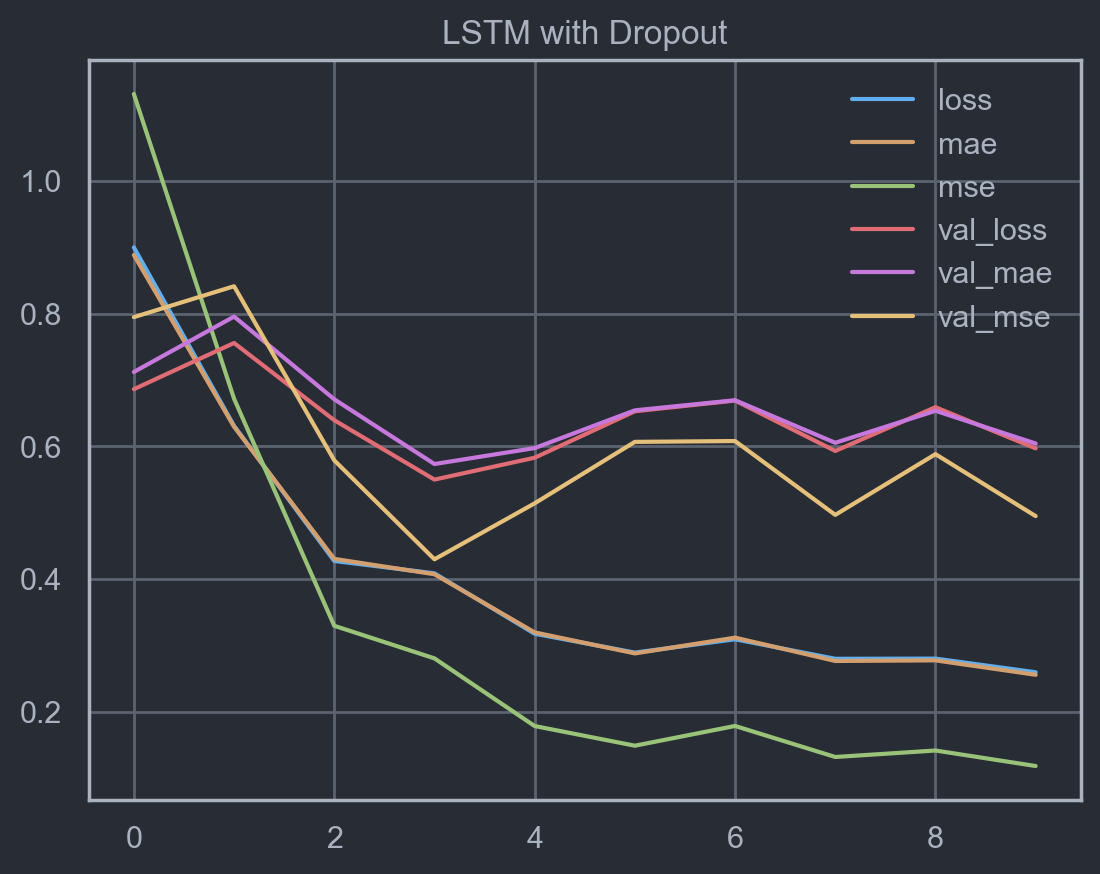

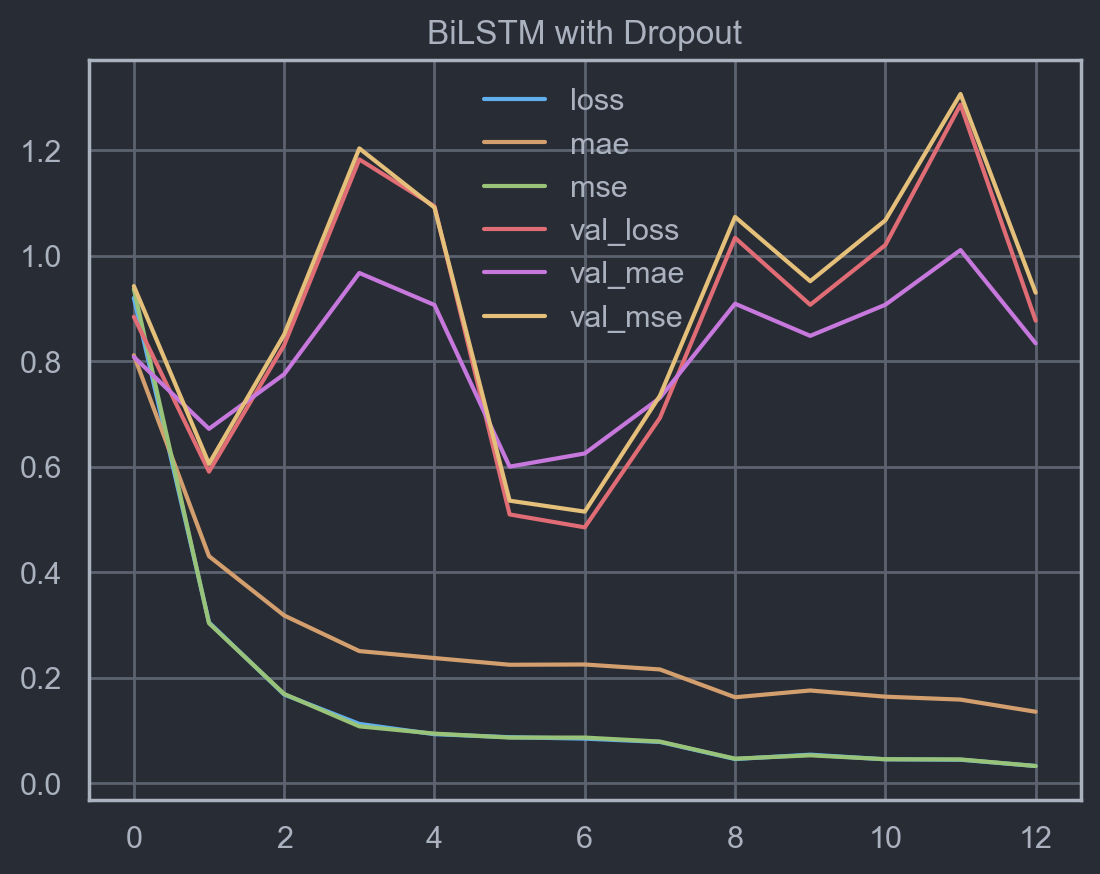

In [259]:
model_bilstm.history.model.summary()

# Plotting
plt.figure(figsize=(10, 5))
pd.DataFrame(history_lstm.history).plot(title='LSTM with Dropout')
pd.DataFrame(history_bilstm.history).plot(title='BiLSTM with Dropout')
pd.DataFrame(history_bilstm.history).to_clipboard()

In [292]:
metric_results = {model_name: model_results[model_name]['metrics'] for model_name in model_results.keys() if 'metrics' in model_results[model_name]}
model_results_df = pd.DataFrame(metric_results).T[1:]

display(model_results_df)

plt.style.use('custom_onedark')

metric_results = {model_name: model_results[model_name]['metrics'] for model_name in model_results.keys() if 'metrics' in model_results[model_name]}

# Create a larger figure
plt.figure(figsize=(12, 8))
model_results_df = pd.DataFrame(metric_results).T[1:]
model_results_df.plot(kind='bar', figsize=(10, 7))

plt.title('Evaluation Metrics Across Models of Varying Complexity', fontsize=16, y=1.06, pad=20)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
legend = plt.legend(['R2', 'MAE', 'MSE', 'RMSE'], 
    loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

plt.xlabel('Models', fontsize=15)
plt.ylabel('Metrics', fontsize=15)

plt.xticks(fontsize=12, rotation=30)
plt.yticks(fontsize=12)

plt.tight_layout(pad=2)
plt.show()

r2       mae       mse      rmse
KNeighborsRegressor       -0.058541  0.908133  1.183211  1.087755
GradientBoostingRegressor  0.555634  0.576609  0.496701  0.704770
RandomForestRegressor      0.600280  0.531549  0.446797  0.668429
LGBMRegressor              0.571908  0.553505  0.478511  0.691745
Vanilla LSTM               0.437228  0.696046  0.661891  0.813567
Deeper LSTM                0.536244  0.617849  0.545436  0.738536
LSTM                       0.541141  0.586940  0.539676  0.734626
BiLSTM with Dropout        0.446981  0.675109  0.650419  0.806486

<Figure size 1200x800 with 0 Axes>

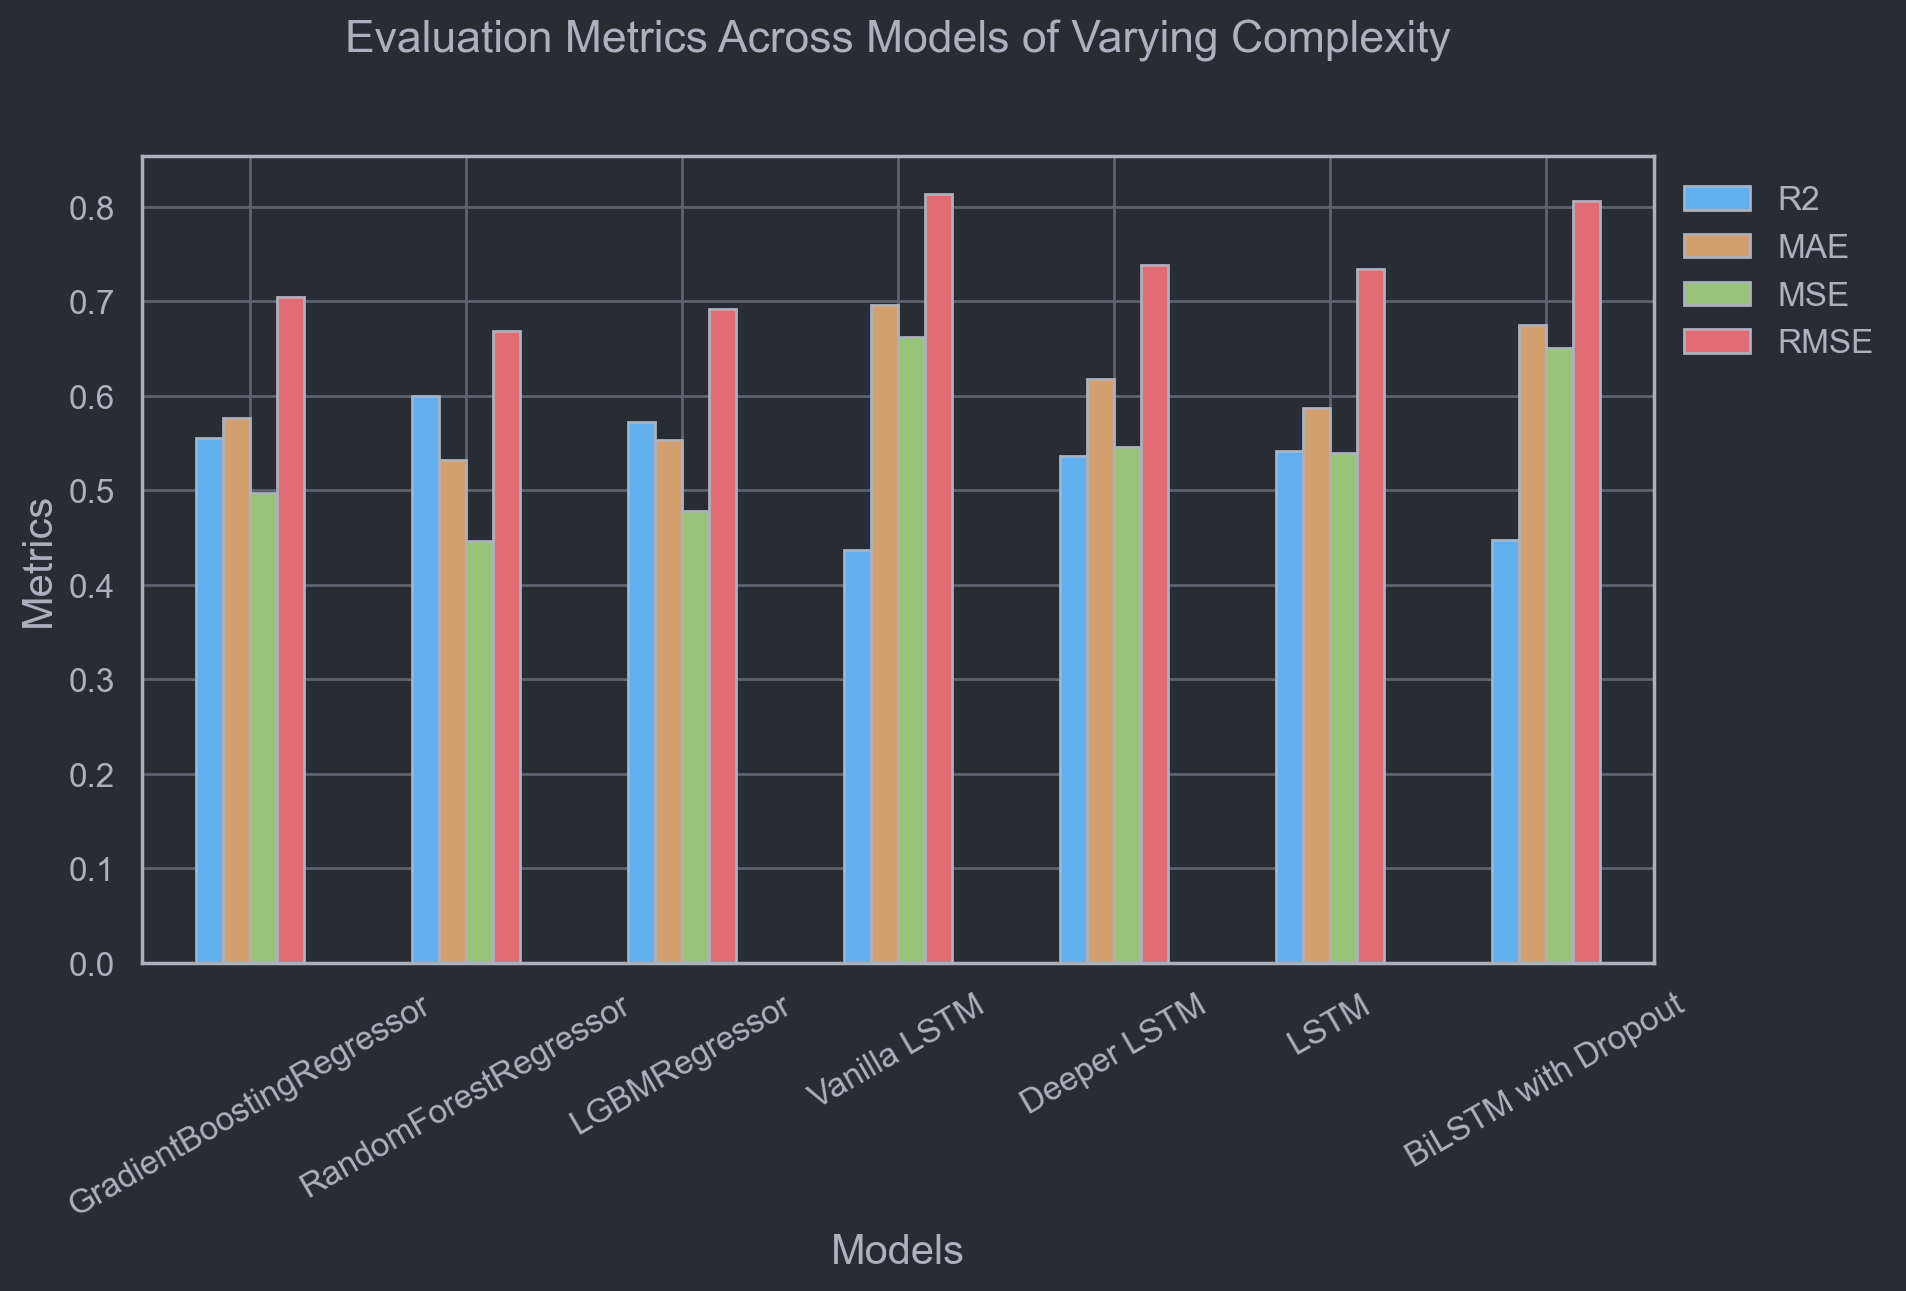

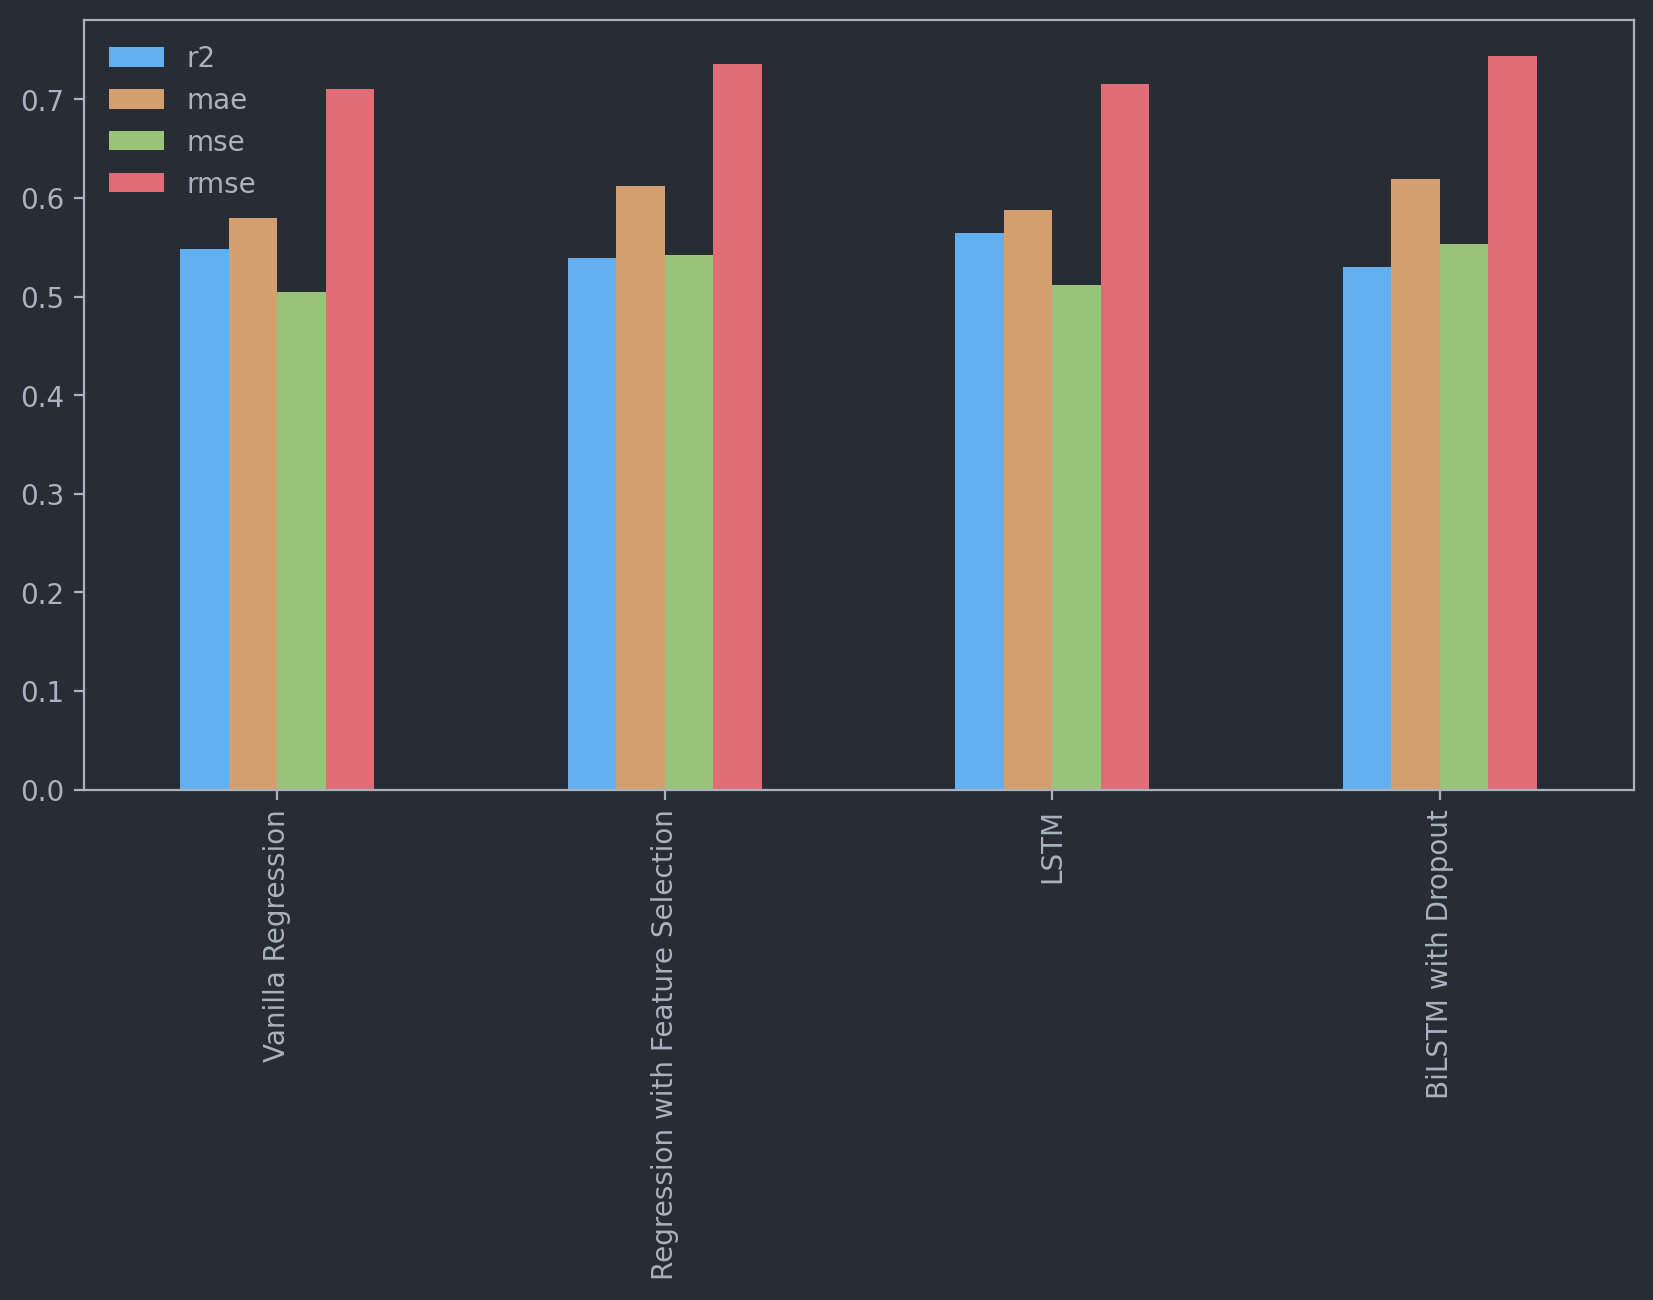

In [228]:
# elvaluate model results to dataframe and plot bar
model_results_df = pd.DataFrame(model_results).T
model_results_df.plot(kind='bar', figsize=(10, 5))
plt.title('Model Results')
plt.show()


In [ ]:
# elvaluate model results to dataframe and plot bar
model_results_df = pd.DataFrame(model_results).T
model_results_df.plot(kind='bar', figsize=(10, 5))
plt.show()


In [ ]:
#import arima
from statsmodels.tsa.arima.model import ARIMA

# supress warnings
import warnings
warnings.filterwarnings("ignore")


# for each pairs, run the models
model_results = {}
for pair in pairs:
    print(pair)
    # Join Sentiment and add Sentiment Moving Averages if ADD_SENTIMENT_MA is True
    pair_sentiment_df = pd.merge( data[pair[0]].sentiment, data[pair[1]].sentiment, left_index=True, right_index=True, suffixes=("_S1", "_S2"),)
    if ADD_SENTIMENT_MA:
        pair_sentiment_df = add_moving_averages(pair_sentiment_df, [5, 10, 20, 40, 80], columns=pair_sentiment_df.columns)

    # Join Technical Indicators
    pair_ti_df = pd.merge( data[pair[0]].ti, data[pair[1]].ti, left_index=True, right_index=True, suffixes=("_S1", "_S2"))
    pair_df = pd.merge(pair_ti_df, pair_sentiment_df, left_index=True, right_index=True, how="left")

    # Calculate Spread
    spread = get_spread(pair_df['Adj Close_S1'], pair_df['Adj Close_S2'], window=SPREAD_WINDOW)
    pair_df['spread'] = spread

    # Calculate Moving Z score Calculation (Trading Signal)
    ma_high = pair_df.spread.rolling(window=MA_HIGH).mean()
    ma_low = pair_df.spread.rolling(window=MA_LOW).mean()
    std_high = pair_df.spread.rolling(window=MA_HIGH).std()

    moving_zscore = (ma_low - ma_high) / std_high
    pair_df['zscore_spread'] = moving_zscore

    train_data, val_data, test_data = create_dataset(
        pair_df, 
        look_back=LOOK_BACK, 
        target_col="zscore_spread", 
        drop_cols=DROP_COLS
    )

    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)

    # Combine val and test data since were not using Deep learning or hyper-param tuning 
    X_test = pd.concat([X_val, X_test])
    y_test = pd.concat([y_val, y_test])

    model_reg = LinearRegression()
    model_reg.fit(X_train, y_train)

    y_pred_linear = model_reg.predict(X_test)

    model_results['Vanilla Regression'] = calculate_metrics(y_test, y_pred_linear)

    # # ARIMA model
    
    # arima_model = ARIMA(y_train, order=(5, 1, 0))
    # arima_model_fit = arima_model.fit()
    # y_pred_arima = arima_model_fit.forecast(len(y_test))[0]
    
    # model_results['ARIMA'] = calculate_metrics(y_test, y_pred_arima)
    
    
    
    # lstm
    padding_train = calculate_padding(X_train.shape[1], LOOK_BACK)
    padding_test = calculate_padding(X_test.shape[1], LOOK_BACK)
    
    # Pad both training and testing feature sets
    X_train_padded = np.pad(X_train.values, ((0, 0), (0, padding_train)), 'constant', constant_values=0)
    X_test_padded = np.pad(X_test.values, ((0, 0), (0, padding_test)), 'constant', constant_values=0)
    
    # Reshape both sets for LSTM
    X_train_lstm = X_train_padded.reshape((X_train.shape[0], LOOK_BACK, -1))
    X_test_lstm = X_test_padded.reshape((X_test.shape[0], LOOK_BACK, -1))
    
    # Build the LSTM model
    model_lstm = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        Dropout(0.2),  # Dropout for regularizing and preventing overfitting
        LSTM(50),
        Dense(1)  # Output layer
        
    ])
    
    model_lstm.compile(optimizer='adam', loss='mse')
    
    # Fit the model
    model_lstm.fit(X_train_lstm, y_train, epochs=100, validation_split=0.1, verbose=0)
    
    # Predict
    y_pred_lstm = model_lstm.predict(X_test_lstm)
    
    # Evaluate
    model_results['LSTM'] = calculate_metrics(y_test, y_pred_lstm.flatten())
    
    # Build the Bidirectional LSTM model
    model_bilstm = Sequential([
        Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        Dropout(0.2),  # Dropout for regularizing and preventing overfitting
        Bidirectional(LSTM(50)),
        Dense(1)  # Output layer
    ])
    
    model_bilstm.compile(optimizer='adam', loss='mse')
    
    # Fit the model
    model_bilstm.fit(X_train_lstm, y_train, epochs=100, validation_split=0.1, verbose=0)
    
    # Predict
    y_pred_bilstm = model_bilstm.predict(X_test_lstm)
    
    # Evaluate
    model_results['BiLSTM with Dropout'] = calculate_metrics(y_test, y_pred_bilstm.flatten())
    
    # plot all together and show one loop in one plot

    plt.figure(figsize=(10, 5))
    plt.title(f'{pair[0]} vs {pair[1]}')
    plt.plot(y_test.index, y_test, label="Actual")
    plt.plot(y_test.index, y_pred_linear, label="Predicted Linear")
    plt.plot(y_test.index, y_pred_lstm.flatten(), label="Predicted LSTM")
    plt.plot(y_test.index, y_pred_bilstm.flatten(), label="Predicted BiLSTM with Dropout")
    plt.legend()
    plt.show()
    
    # elvaluate model results to dataframe and plot bar
    model_results_df = pd.DataFrame(model_results).T
    model_results_df.plot(kind='bar', figsize=(10, 5))
    plt.show()
    
    # print model results
    print(model_results_df)
    
    # save pickle
    
    model_results_df.to_pickle(f'../data/model_results/{pair[0]}_{pair[1]}_model_results.pkl')
    
    
    